#Unsupervised Analysis

The goal of this analysis is to find clusters of similar CBSAs based on the pollutant profiles of the six key pollutants: 'PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE'.  The codebook in our DataCollection&Cleaning.ipynb explains in detail each of these variables.  Both hierarchical clustering and kmeans clustering were used to find various clustering schemes that we compared to one another and checked for stability.

Once clusters were found, we compared clusters to see if there were significant differences in mean pollutant levels.  The goal is to answer the question: do clusters have distinct pollutant profiles that separate them?

Then we looked at multinomial regressions with variables related to population, area, weather, and commuting.  We wanted to see if we could find a predictive model, based on these other determinants, that could predict which cluster a city without pollutant meansures, would fall into based on such weather, population, etc. data.  Such a model would be useful for could predicting the pollutant profiles of cities in the third world, where such measuring of pollutants is not available.  In terms of pollicies, this might help those cities chose targeted air pollution reforms based on knowing which reforms worked best for cities with similar demographics.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
from time import time

#from rpy2.robjects.packages import importr
#import rpy2.robjects as ro
#import pandas.rpy.common as com

###Yearly Data Exploratory Analysis
Since pollutant levels over the year do not seem to vary much, we completed this analysis with the yearly data we had cleaned.

In [2]:
#Read in yearly data
#YearDat = pd.read_csv('YearDat.csv')  #has non-complete weather data
YearDat = pd.read_csv('YearDat2.csv') #has no incomplete data for covariates


### Complete Case Analysis
If we subset our yearly data to cities for which we have no missing data, we have data on 80 cities.  Our YearDat.csv file has data on 533 cities in total so we lose a lot of data when we do this.  However, hierarchical clustering needs complete cases in order to work; with missing data it uses infinity as the 'distance' and thus the algorithm cannot run.

In [3]:
#Get only complete observations
#This reduces the sample down to 80 cities only...
a = YearDat[['CBSA Name','PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE']]
a = a.dropna()
b = a [['PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE']]

In [4]:
#Code from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
import scipy.cluster.hierarchy as hac
X = np.array(b)
Z = hac.linkage(X, 'average')

/Users/elizabethcheever/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


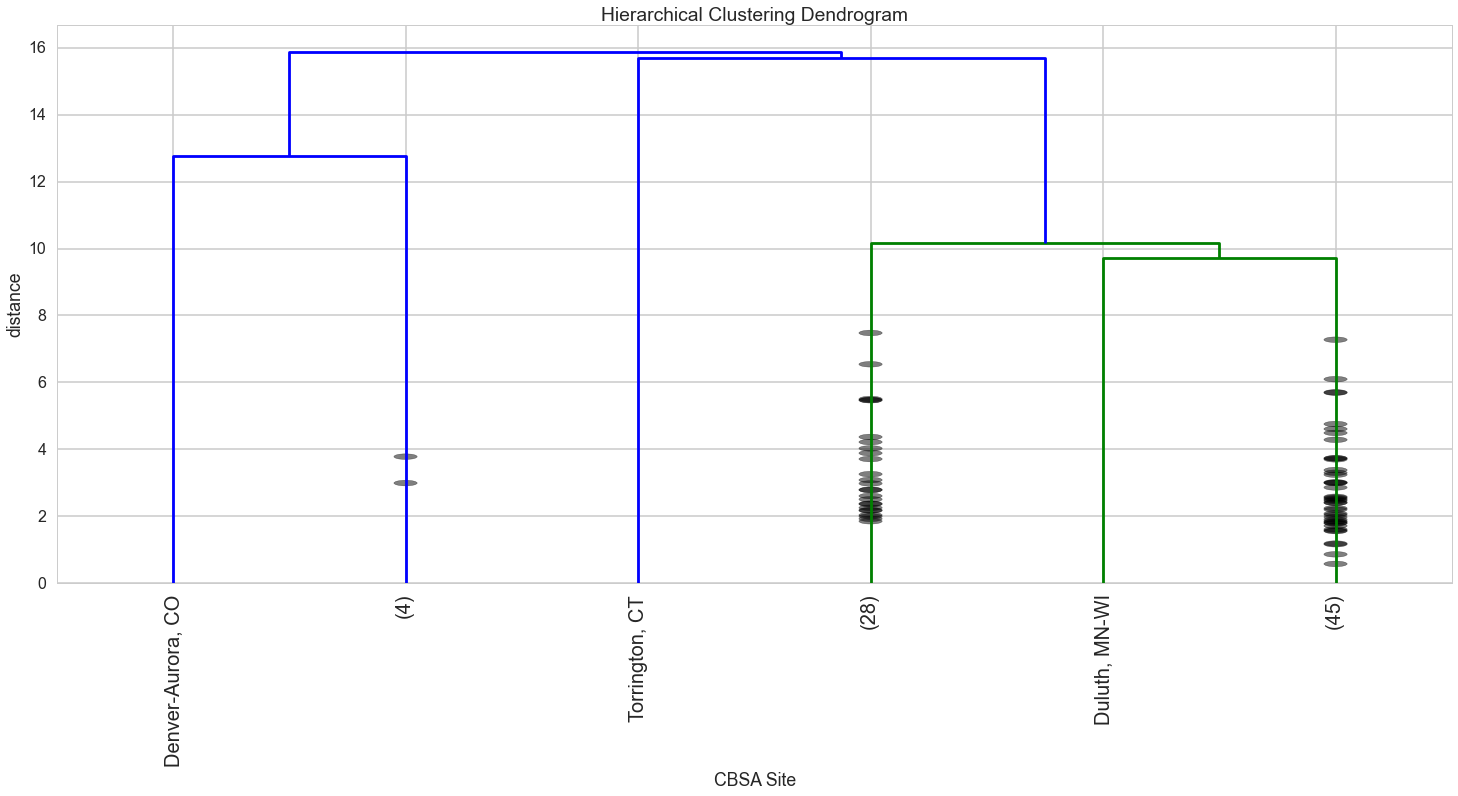

In [5]:
#Code from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
#Plot the dendogram so clusters can be seen visually
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('CBSA Site')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    truncate_mode='lastp',
    p=6,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    show_contracted=True,
    labels = np.array(a['CBSA Name'])
)
plt.show()

Now we retrieve the clusters that have been determined.  Using the dendogram above we determine the max distance.  The code below allows us to get the cluster id for each CBSA site.

In [6]:
#More from 
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import fcluster
max_d = 9
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 1, 2, 4, 3, 5, 1, 3, 4, 4,
       3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 4,
       3, 1, 3, 4, 4, 4, 4, 3, 4, 3, 4, 4, 1, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3,
       4, 6, 3, 4, 4, 4, 3, 4, 4, 4, 3], dtype=int32)

In [7]:
a['label']=clusters

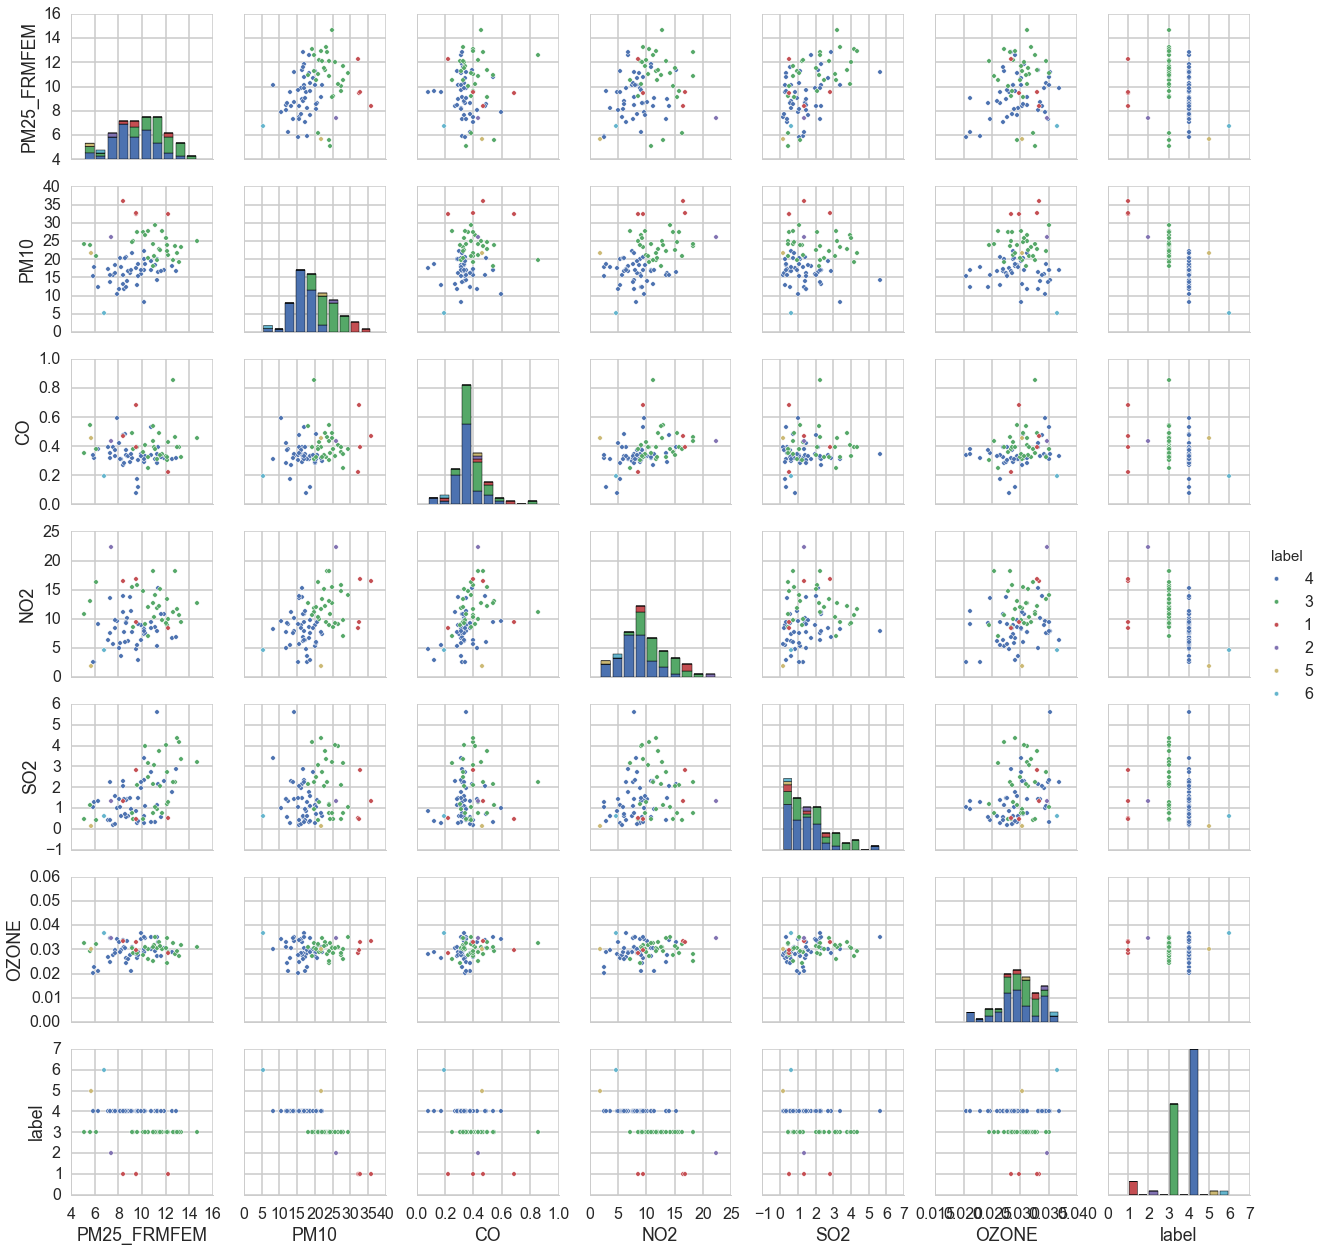

In [8]:
sns.pairplot(a, hue="label")

We can also try to determine k (the number of clusters) using the elbow method.  The method's goal is to find the clustering step where the acceleration of distance growth is the biggest.  In the graph it will be the "strongest elbow of the blue line graph, which is the highest value of the green graph."  For our clustering we see that this method suggests there are 4 distinct clusters.

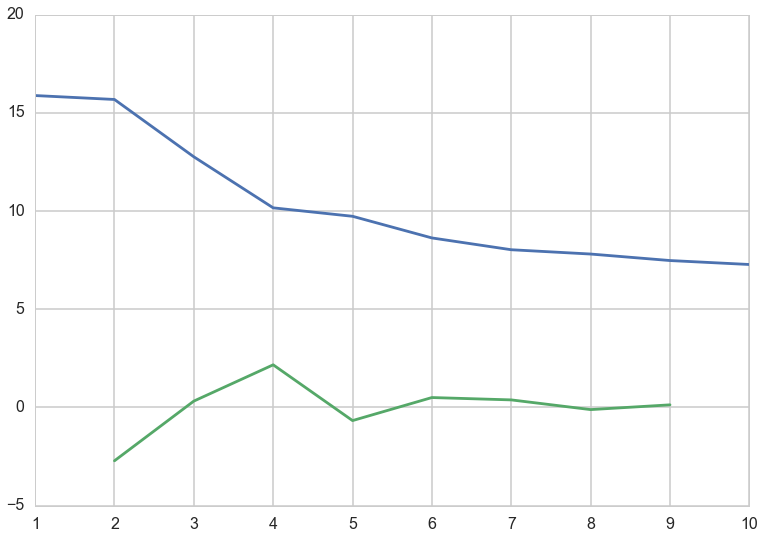

clusters: 4


In [9]:
#More from 
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k

### Hierarchical Clustering with All Data (n=533)
Each method I tried to implement did not work given the fact that their were NaNs in the data.  When the distance matrix is computed to have NaNs as distances, we cannot compute linkages.

In [10]:
#From: http://stackoverflow.com/questions/31420912/python-hierarchical-clustering-with-missing-values

def getMissDist(x,y):  #compute Euclidean distance
    return np.nanmean( (x - y)**2 )

def getMissDistMat(dat):
    Npat = dat.shape[0]
    dist = np.ndarray(shape=(Npat,Npat))
    dist.fill(0)
    for ix in range(0,Npat):
        x = dat[ix,]
        if ix >0:
            for iy in range(0,ix):
                y = dat[iy,]
                dist[ix,iy] = getMissDist(x,y)
                dist[iy,ix] = dist[ix,iy]
    return dist

In [19]:
import fastcluster
import scipy.cluster.hierarchy
import scipy.spatial.distance as dist

nonComplete = YearDat[['PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE']]
nonComplete = nonComplete.dropna(how='all') #remove rows if ALL are NA

distMat = getMissDistMat(nonComplete.as_matrix())
condensDist = dist.squareform(distMat,checks=False)
link = scipy.cluster.hierarchy.linkage(condensDist, method='average')
scipy.cluster.hierarchy.dendrogram(link)

/Users/elizabethcheever/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


ValueError: Linkage 'Z' contains negative indices.

### K Means
Here we apply a second method to group our CBSAs into subsets with similar pollution profiles.  The goal is that all CBSAs within a group are more similar amongst themselves than they are to the others. The hope is that this clustering will show that there is some sort of structure around pollutant profiles that separates them.  Note that Euclidean distance is used by this algorithm.


In [11]:
#Source: http://www.kosbie.net/cmu/fall-10/15-110/handouts/notes-clustering/kmeans.py
import math
import random
import time

def distance(instance1, instance2):
    if instance1 == None or instance2 == None:
        return float("inf")
    sumOfSquares = 0
    for i in range(1, len(instance1)): #Euclidean distance used
        sumOfSquares += (instance1[i] - instance2[i])**2
    return sumOfSquares

def meanInstance(name, instanceList):
    numInstances = len(instanceList)
    if (numInstances == 0):
        return
    numAttributes = len(instanceList[0])
    means = [name] + [0] * (numAttributes-1)
    for instance in instanceList:
        for i in range(1, numAttributes):
            means[i] += instance[i]
    for i in range(1, numAttributes):
        means[i] /= float(numInstances)
    return tuple(means)

def assign(instance, centroids):
    minDistance = distance(instance, centroids[0])
    minDistanceIndex = 0
    for i in range(1, len(centroids)):
        d = distance(instance, centroids[i])
        if (d < minDistance):
            minDistance = d
            minDistanceIndex = i
    return minDistanceIndex

def createEmptyListOfLists(numSubLists):
    myList = []
    for i in range(numSubLists):
        myList.append([])
    return myList

def assignAll(instances, centroids):
    clusters = createEmptyListOfLists(len(centroids))
    for instance in instances:
        clusterIndex = assign(instance, centroids)
        clusters[clusterIndex].append(instance)
    return clusters

def computeCentroids(clusters):
    centroids = []
    for i in range(len(clusters)):
        name = "centroid" + str(i)
        centroid = meanInstance(name, clusters[i])
        centroids.append(centroid)
    return centroids


def kmeans(instances, k, animation=False, initCentroids=None):
    result = {}
    if (initCentroids == None or len(initCentroids) < k):
        # randomly select k initial centroids
        random.seed(time.time())
        centroids = random.sample(instances, k)
    else:
        centroids = initCentroids
    prevCentroids = []
    if animation:
        delay = 1.0 # seconds
        canvas = prepareWindow(instances)
        clusters = createEmptyListOfLists(k)
        clusters[0] = instances
        paintClusters2D(canvas, clusters, centroids, "Initial centroids")
        time.sleep(delay)
    iteration = 0
    while (centroids != prevCentroids):  #while centroids haven't converged
        iteration += 1
        clusters = assignAll(instances, centroids)
        if animation:
            paintClusters2D(canvas, clusters, centroids, "Assign %d" % iteration)
            time.sleep(delay)
        prevCentroids = centroids
        centroids = computeCentroids(clusters)
        withinss = computeWithinss(clusters, centroids)
        if animation:
            paintClusters2D(canvas, clusters, centroids,
                            "Update %d, withinss %.1f" % (iteration, withinss))
            time.sleep(delay)
    result["clusters"] = clusters
    result["centroids"] = centroids
    result["withinss"] = withinss
    return result


def computeWithinss(clusters, centroids):
    result = 0
    for i in range(len(centroids)):
        centroid = centroids[i]
        cluster = clusters[i]
        for instance in cluster:
            result += distance(centroid, instance)
    return result

# Repeats k-means clustering n times, and returns the clustering
# with the smallest withinss
def repeatedKMeans(instances, k, n):
    bestClustering = {}
    bestClustering["withinss"] = float("inf")
    for i in range(1, n+1):
        #print "k-means trial %d," % i ,
        trialClustering = kmeans(instances, k)
        #print "withinss: %.1f" % trialClustering["withinss"]
        if trialClustering["withinss"] < bestClustering["withinss"]:
            bestClustering = trialClustering
            minWithinssTrial = i
    #print "Trial with minimum withinss:", minWithinssTrial
    return bestClustering


def printTable(instances):
    for instance in instances:
        if instance != None:
            line = instance[0] + "\t"
            for i in range(1, len(instance)):
                line += "%.2f " % instance[i]
            print line

In [12]:
#First convert our data set into a tuple
dataset = []
for index, row in a.iterrows():
    rowTuple = tuple(row.tolist())
    dataset.append(rowTuple) 
print dataset[1:3]  #a check to see if this is producing the right format

[('Atlanta-Sandy Springs-Marietta, GA', 12.565564477999999, 18.226640159000002, 0.31446663578, 6.76288457091, 1.76367937445, 0.0290734801247, 4), ('Baltimore-Towson, MD', 11.3823322243, 16.3352941176, 0.391456824305, 15.3235823181, 2.15056786798, 0.0331415046613, 4)]


In [13]:
#Do the kmeans clustering
clustering =kmeans(dataset,4)

#Print the centroid data ('PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE')
printTable(clustering["centroids"])
print

#Print out each of the clusters
for i in xrange(0,len(clustering["clusters"])): #for each cluster list
    cbsa_names = []
    for tup in clustering["clusters"][i]:    #go through the tuples
        cbsa_names.append(tup[0])   #pull out the CBSA name and append to list
    #print the clusters
    print 'Cluster %d'% i
    print '%d CBSAs in this cluster' % len(cbsa_names)
    #print cbsa_names
    #print

centroid0	9.99 18.61 0.35 8.65 1.43 0.03 3.81 
centroid1	8.20 12.24 0.34 7.43 1.63 0.03 4.14 
centroid2	10.43 29.58 0.39 10.93 1.86 0.03 2.20 
centroid3	9.95 24.04 0.42 15.00 1.84 0.03 2.93 

Cluster 0
42 CBSAs in this cluster
Cluster 1
14 CBSAs in this cluster
Cluster 2
10 CBSAs in this cluster
Cluster 3
14 CBSAs in this cluster


When we run the code over and over, the sizes of the clusters keep varying.  Thus we run the clustering 1000 times and return the clustering with the smallest withinss (meaning 'tightest' clusters).

In [14]:
#Do the kmeans clustering over and over
clustering_stable = repeatedKMeans(dataset,4, 1000)

#Print the centroid data ('PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE')
printTable(clustering_stable["centroids"])
print

#Print out each of the clusters
for i in xrange(0,len(clustering_stable["clusters"])): #for each cluster list
    cbsa_names = []
    for tup in clustering_stable["clusters"][i]:    #go through the tuples
        cbsa_names.append(tup[0])   #pull out the CBSA name and append to list
    #print the clusters
    print 'Cluster %d'% i
    print '%d CBSAs in this cluster' % len(cbsa_names)
    print cbsa_names
    print

centroid0	10.70 19.45 0.39 11.46 1.88 0.03 3.48 
centroid1	9.98 27.48 0.41 13.19 1.63 0.03 2.53 
centroid2	8.94 18.33 0.32 5.65 1.01 0.03 4.05 
centroid3	8.64 12.26 0.33 8.13 1.79 0.03 4.14 

Cluster 0
27 CBSAs in this cluster
['Allentown-Bethlehem-Easton, PA-NJ', 'Baltimore-Towson, MD', 'Boise City-Nampa, ID', 'Charlotte-Gastonia-Concord, NC-SC', 'Cincinnati-Middletown, OH-KY-IN', 'Cleveland-Elyria-Mentor, OH', 'Des Moines-West Des Moines, IA', 'Detroit-Warren-Livonia, MI', 'Evansville, IN-KY', 'Greenville-Mauldin-Easley, SC', 'Houston-Sugar Land-Baytown, TX', 'Jacksonville, FL', 'Johnstown, PA', 'Little Rock-North Little Rock-Conway, AR', 'Memphis, TN-MS-AR', 'New Haven-Milford, CT', 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD', 'Pittsburgh, PA', 'Portland-South Portland-Biddeford, ME', 'Reno-Sparks, NV', 'San Francisco-Oakland-Fremont, CA', 'San Jose-Sunnyvale-Santa Clara, CA', 'Tulsa, OK', 'Washington-Arlington-Alexandria, DC-VA-MD-WV', 'Winston-Salem, NC', 'Worcester, MA', 'York-

When we run this over and over we see the same clusters being reproduced each time. This shows that there is some sort of structure present across the 6 pollutants that we are looking at.

In [15]:
#Make a dataframe based on cluster data
d=[]
for i in xrange(0,len(clustering_stable["clusters"])):  #for each cluster
    for tup in clustering_stable["clusters"][i]:    #go through the tuples
        d.append({'Cluster':i,'CBSA':tup[0],'PM25_FRMFEM':tup[1],'PM10':tup[2],'CO':tup[3],'NO2':tup[4],'SO2':tup[5],'OZONE':tup[6]})
  

dfClusters=pd.DataFrame(d)
dfClusters.head()

,CBSA,CO,Cluster,NO2,OZONE,PM10,PM25_FRMFEM,SO2
0,"Allentown-Bethlehem-Easton, PA-NJ",0.320375,0,10.760570,0.030632,17.064607,11.894283,2.286398
1,"Baltimore-Towson, MD",0.391457,0,15.323582,0.033142,16.335294,11.382332,2.150568
2,"Boise City-Nampa, ID",0.311235,0,8.629604,0.029370,18.307471,11.134189,0.334688
3,"Charlotte-Gastonia-Concord, NC-SC",0.314959,0,11.787743,0.030348,19.712381,11.270964,0.933421
4,"Cincinnati-Middletown, OH-KY-IN",0.326002,0,9.373849,0.031885,23.262295,13.283674,3.369288


In [ ]:
#Save this dataframe to a .csv to be used in Supervised Learning
dfClusters.to_csv("dfClusters_kMeans.csv",index=False,na_rep='NA')

### Pollutant profiles by cluster
Now we look at the profiles for the 4 clusters in terms of the six pollutants to see if there are strong trends.

are there any strong trends? So like, is cluster 0 the 'bad' CO and NO2 and cluster1 like 'bad' PM2.5 and PM10? Or something clear like that? If that's the case, we may be able to infer the most likely classification of some of the sites with data for only 4 or 5 pollutants (especially if some of the pollutants are highly correlated). I think that's basically what imputation would end up doing if we tried to impute the missing values.

In [16]:
d=[]
for i in xrange(0,len(clustering_stable["clusters"])):  #For each cluster
    #Store the means of the pollutants: 'PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE'
    mean_PM25_FRMFEM = []
    mean_PM10 = []
    mean_CO=[]
    mean_NO2=[]
    mean_SO2=[]
    mean_OZONE=[]
    
    for tup in clustering_stable["clusters"][i]:    #go through the tuples
        #store the pollutant value so the mean can be calculated
        mean_PM25_FRMFEM.append(tup[1])
        mean_PM10.append(tup[2])
        mean_CO.append(tup[3])
        mean_NO2.append(tup[4])
        mean_SO2.append(tup[5])
        mean_OZONE.append(tup[6])
    #create row for data frame to hold the means
    d.append({'Cluster':i,'Mean_PM25_FRMFEM':np.mean(mean_PM25_FRMFEM),'Mean_PM10':np.mean(mean_PM10),'Mean_CO':np.mean(mean_CO),'Mean_NO2':np.mean(mean_NO2),'Mean_SO2':np.mean(mean_SO2),'Mean_OZONE':np.mean(mean_OZONE)})
    
dfMeans=pd.DataFrame(d)
print dfMeans

   Cluster   Mean_CO   Mean_NO2  Mean_OZONE  Mean_PM10  Mean_PM25_FRMFEM  Mean_SO2
0  0        0.388062  11.455170  0.029811    19.452519  10.695563         1.881085
1  1        0.410467  13.192576  0.030213    27.482895  9.975703          1.632274
2  2        0.321432  5.645705   0.028988    18.325467  8.944889          1.010723
3  3        0.332635  8.128132   0.030928    12.260108  8.644016          1.791130


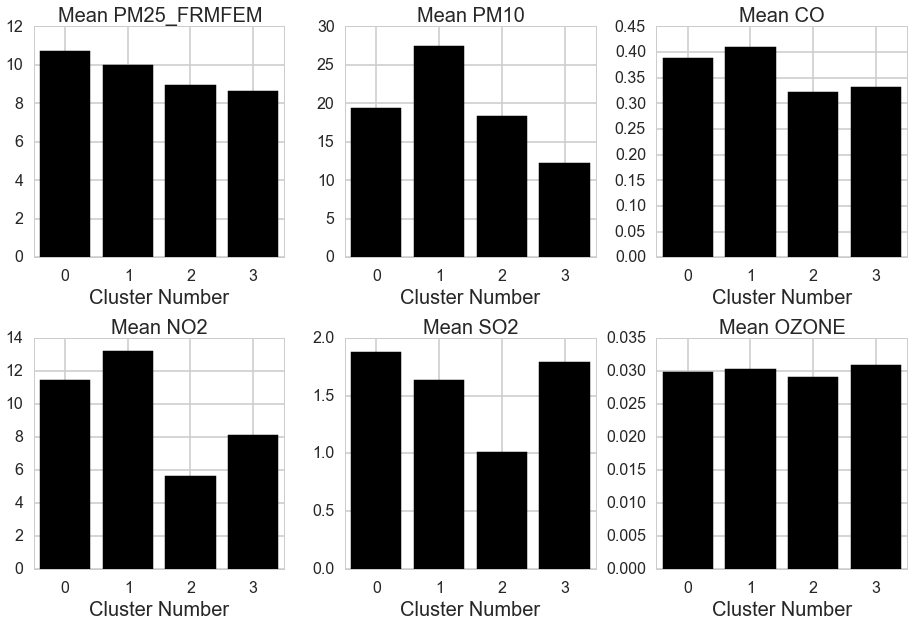

In [17]:
#Make a bar chart to visualize differences
#fig = plt.figure(figsize=(90,60))
names=['0','1','2','3']
plt.subplot(2, 3, 1)
plt.bar(dfMeans['Cluster'],dfMeans['Mean_PM25_FRMFEM'],color='black',align='center')
plt.title('Mean PM25_FRMFEM',fontsize=20)
plt.xticks(dfMeans['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=20)

plt.subplot(2, 3, 2)
plt.bar(dfMeans['Cluster'],dfMeans['Mean_PM10'],color='black',align='center')
plt.title('Mean PM10',fontsize=20)
plt.xticks(dfMeans['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=20)

plt.subplot(2, 3, 3)
plt.bar(dfMeans['Cluster'],dfMeans['Mean_CO'],color='black',align='center')
plt.title('Mean CO',fontsize=20)
plt.xticks(dfMeans['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=20)
  
plt.subplot(2, 3, 4)
plt.bar(dfMeans['Cluster'],dfMeans['Mean_NO2'],color='black',align='center')
plt.title('Mean NO2',fontsize=20)
plt.xticks(dfMeans['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=20)

plt.subplot(2, 3, 5)
plt.bar(dfMeans['Cluster'],dfMeans['Mean_SO2'],color='black',align='center')
plt.title('Mean SO2',fontsize=20)
plt.xticks(dfMeans['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=20)

plt.subplot(2, 3, 6)
plt.bar(dfMeans['Cluster'],dfMeans['Mean_OZONE'],color='black',align='center')
plt.title('Mean OZONE',fontsize=20)
plt.xticks(dfMeans['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=20)

plt.tight_layout()

Visually it appears that clusters may be most separated by PM_10, NO2, and SO2.

###Statistically significant difference amongst groups?
Here we use a one-way ANOVA to invetigate the difference amongst the clusters.  
Assumptions for this test:
1. Samples are independent.  We assume that this is true given that the data comes from different cities.
2. Underlying populations are normally distributed. 
3. Samples should all have the same standard deviation.

Below we examine the historgrams for each pollutant by cluster to see if assumptions of normality and homoscedasticity hold.

(array([  46.20212682,    0.        ,   46.20212682,   46.20212682,
          46.20212682,   46.20212682,   92.40425364,   46.20212682,
         184.80850728,   92.40425364]),
 array([ 0.02108921,  0.02263521,  0.02418122,  0.02572722,  0.02727322,
         0.02881922,  0.03036522,  0.03191122,  0.03345723,  0.03500323,
         0.03654923]),
 <a list of 10 Patch objects>)

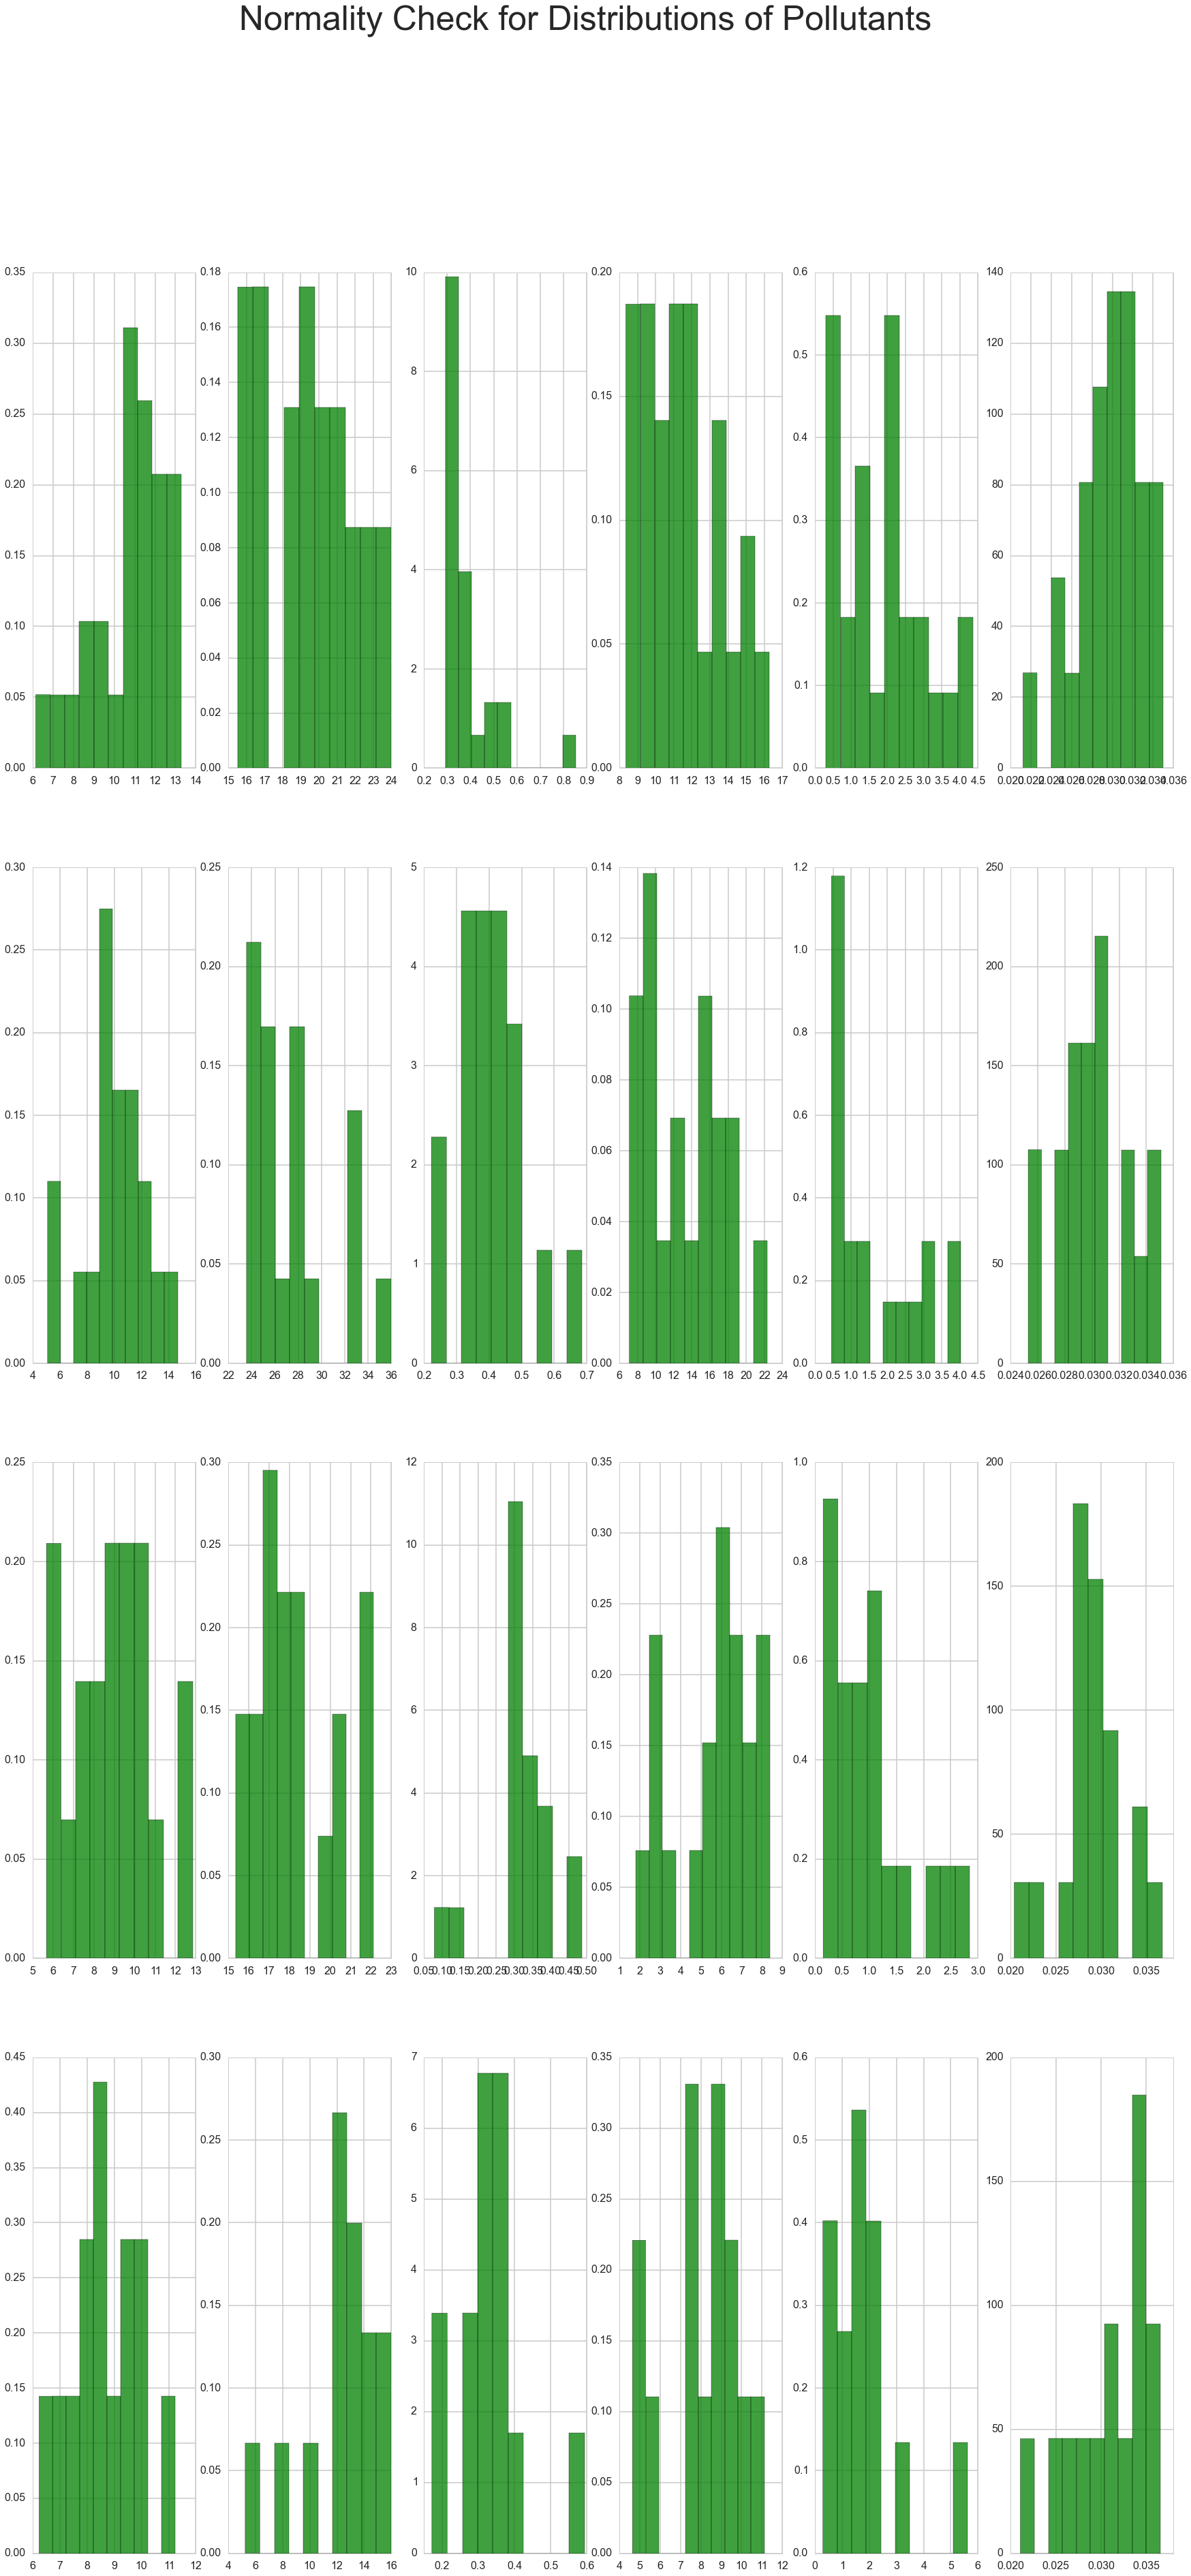

In [18]:
#Check histogram for each pollutant for normality
fig = plt.figure(figsize=(30,60))
fig.suptitle("Normality Check for Distributions of Pollutants", fontsize=50,verticalalignment='bottom')
ax=plt.subplot(4, 6, 1)
ax.hist(dfClusters[dfClusters['Cluster']==0]['PM25_FRMFEM'].values, 10, normed=1, facecolor='green', alpha=0.75)
ax=plt.subplot(4, 6, 2)
ax.hist(dfClusters[dfClusters['Cluster']==0]['PM10'].values, 10, normed=1, facecolor='green', alpha=0.75)
ax=plt.subplot(4, 6, 3)
ax.hist(dfClusters[dfClusters['Cluster']==0]['CO'].values, 10, normed=1, facecolor='green', alpha=0.75)
ax=plt.subplot(4, 6, 4)
ax.hist(dfClusters[dfClusters['Cluster']==0]['NO2'].values, 10, normed=1, facecolor='green', alpha=0.75)
ax=plt.subplot(4, 6, 5)
ax.hist(dfClusters[dfClusters['Cluster']==0]['SO2'].values, 10, normed=1, facecolor='green', alpha=0.75)
ax=plt.subplot(4, 6, 6)
ax.hist(dfClusters[dfClusters['Cluster']==0]['OZONE'].values, 10, normed=1, facecolor='green', alpha=0.75)
ax=plt.subplot(4, 6, 7)
ax.hist(dfClusters[dfClusters['Cluster']==1]['PM25_FRMFEM'].values, 10,normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 8)
plt.hist(dfClusters[dfClusters['Cluster']==1]['PM10'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 9)
plt.hist(dfClusters[dfClusters['Cluster']==1]['CO'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 10)
plt.hist(dfClusters[dfClusters['Cluster']==1]['NO2'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 11)
plt.hist(dfClusters[dfClusters['Cluster']==1]['SO2'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 12)
plt.hist(dfClusters[dfClusters['Cluster']==1]['OZONE'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 13)
plt.hist(dfClusters[dfClusters['Cluster']==2]['PM25_FRMFEM'].values, 10,normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 14)
plt.hist(dfClusters[dfClusters['Cluster']==2]['PM10'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 15)
plt.hist(dfClusters[dfClusters['Cluster']==2]['CO'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 16)
plt.hist(dfClusters[dfClusters['Cluster']==2]['NO2'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 17)
plt.hist(dfClusters[dfClusters['Cluster']==2]['SO2'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 18)
plt.hist(dfClusters[dfClusters['Cluster']==2]['OZONE'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 19)
plt.hist(dfClusters[dfClusters['Cluster']==3]['PM25_FRMFEM'].values, 10,normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 20)
plt.hist(dfClusters[dfClusters['Cluster']==3]['PM10'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 21)
plt.hist(dfClusters[dfClusters['Cluster']==3]['CO'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 22)
plt.hist(dfClusters[dfClusters['Cluster']==3]['NO2'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 23)
plt.hist(dfClusters[dfClusters['Cluster']==3]['SO2'].values, 10, normed=1, facecolor='green', alpha=0.75)
plt.subplot(4, 6, 24)
plt.hist(dfClusters[dfClusters['Cluster']==3]['OZONE'].values, 10, normed=1, facecolor='green', alpha=0.75)
#plt.tight_layout()

As we can see, the assumptions of normality are definitel not met.  Thus a Kruskal Wallis Test, which is a non parametric ANOVA, will be used to determine if statistically significant differences in a pollutant exist between clusters.  The KW test is testing the null hypothesis that the mean pollutant level is the same for all the clusters.

From the results below we can see that for the pollutants of PM25_FRMFEM, PM10, CO, and NO2 had statistically significant p-values.  At the 0.05 alpha level we conclude that the mean pollutant level for these four polluants is not the same for all the clusters.

In [19]:
stat,pval = sp.stats.mstats.kruskalwallis(dfClusters[dfClusters['Cluster']==0]['PM25_FRMFEM'],dfClusters[dfClusters['Cluster']==1]['PM25_FRMFEM'],dfClusters[dfClusters['Cluster']==2]['PM25_FRMFEM'],dfClusters[dfClusters['Cluster']==3]['PM25_FRMFEM'])
print "p-value for PM25_FRMFEM is %0.10f"% pval 
stat,pval = sp.stats.mstats.kruskalwallis(dfClusters[dfClusters['Cluster']==0]['PM10'],dfClusters[dfClusters['Cluster']==1]['PM10'],dfClusters[dfClusters['Cluster']==2]['PM10'],dfClusters[dfClusters['Cluster']==3]['PM10'])
print "p-value for PM10 is %0.10f"% pval  
stat,pval = sp.stats.mstats.kruskalwallis(dfClusters[dfClusters['Cluster']==0]['CO'],dfClusters[dfClusters['Cluster']==1]['CO'],dfClusters[dfClusters['Cluster']==2]['CO'],dfClusters[dfClusters['Cluster']==3]['CO'])
print "p-value for CO is %0.10f"% pval  
stat,pval = sp.stats.mstats.kruskalwallis(dfClusters[dfClusters['Cluster']==0]['NO2'],dfClusters[dfClusters['Cluster']==1]['NO2'],dfClusters[dfClusters['Cluster']==2]['NO2'],dfClusters[dfClusters['Cluster']==3]['NO2'])
print "p-value for NO2 is %0.10f"% pval  
stat,pval = sp.stats.mstats.kruskalwallis(dfClusters[dfClusters['Cluster']==0]['SO2'],dfClusters[dfClusters['Cluster']==1]['SO2'],dfClusters[dfClusters['Cluster']==2]['SO2'],dfClusters[dfClusters['Cluster']==3]['SO2'])
print "p-value for SO2 is %0.10f"% pval  
stat,pval = sp.stats.mstats.kruskalwallis(dfClusters[dfClusters['Cluster']==0]['OZONE'],dfClusters[dfClusters['Cluster']==1]['OZONE'],dfClusters[dfClusters['Cluster']==2]['OZONE'],dfClusters[dfClusters['Cluster']==3]['OZONE'])
print "p-value for OZONE is %0.10f"% pval  


p-value for PM25_FRMFEM is 0.0024369138
p-value for PM10 is 0.0000000000
p-value for CO is 0.0048104626
p-value for NO2 is 0.0000000001
p-value for SO2 is 0.0692575575
p-value for OZONE is 0.3094894042


#####Pairwise testing of clusters by pollutant
I did lots of reading on pairwise comparisons in python and could not find a method that worked.  Thus we used the method of a Wilcoxon rank sum test (non parametric version of a t-test) for each pair and then to do a multiple comparisons correction (Bonferroni) at the end.

The scipy.stats.ranksums function computes the Wilcoxon rank-sum statistic for two samples.  With this method we test the null hypothesis that two sets of measurements are drawn from the same distribution. 

In [25]:
sig_pollutants = ['PM25_FRMFEM','PM10','CO','NO2']  #pollutants that had significant KW test p-values
clusts=[(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]  #all pairwise tests
from statsmodels.sandbox.stats.multicomp import * 
from statsmodels import *
import statsmodels as st

dfPairwiseTests=pd.DataFrame()
for pol in sig_pollutants:
    d = []
    for tup in clusts:
        #preform rank sum test and save p-value
        stat,pval = sp.stats.ranksums(dfClusters[dfClusters['Cluster']==tup[0]][pol], dfClusters[dfClusters['Cluster']==tup[1]][pol])
        d.append({'Pollutant':pol,'Cluster1':tup[0],'Cluster2':tup[1],'pValue':pval})
    #make data frame of all data for the pollutant
    df_tmp=pd.DataFrame(d)
    
    reject,adj_pval,_,_ = st.sandbox.stats.multicomp.multipletests(df_tmp['pValue'],alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
    #Use of bonferroni correction -> correct each set of testing
    #is_sorted=False: assumed input unsorted but corrected pvalues are returned in the original order
    #returnsorted=False: return in unsorted order
    
    df_tmp['adjusted_pValue']=adj_pval  #store adjusted p value
    df_tmp['reject']=reject  #if should reject at given alpha level
    #store in final dataframe
    dfPairwiseTests = dfPairwiseTests.append(df_tmp)
print dfPairwiseTests

   Cluster1  Cluster2    Pollutant        pValue  adjusted_pValue reject
0  0         1         PM25_FRMFEM  2.156576e-01  1.000000e+00     False
1  0         2         PM25_FRMFEM  3.430706e-03  2.058424e-02     True 
2  0         3         PM25_FRMFEM  1.069213e-03  6.415277e-03     True 
3  1         2         PM25_FRMFEM  1.364422e-01  8.186534e-01     False
4  1         3         PM25_FRMFEM  4.513172e-02  2.707903e-01     False
5  2         3         PM25_FRMFEM  6.491774e-01  1.000000e+00     False
0  0         1         PM10         1.365350e-08  8.192100e-08     True 
1  0         2         PM10         1.376383e-01  8.258295e-01     False
2  0         3         PM10         2.730377e-07  1.638226e-06     True 
3  1         2         PM10         9.369849e-08  5.621909e-07     True 
4  1         3         PM10         1.268381e-06  7.610283e-06     True 
5  2         3         PM10         1.372245e-06  8.233470e-06     True 
0  0         1         CO           8.381642e-02  5

From this analysis we can see the statistically significantly differences between clusters.

The mean **PM25_FRMFEM** level differs across clusters 1 and 3 as well as 2 and 3.

The mean **PM10** level of cluster 0 is different from all other clusters.  Additionally, the mean level is different between clusters 1 and 2 as well as 2 and 3.

The mean **CO** level differs across clusters 0 and 1.

The mean **NO2** level of cluster 1 and 2 is different from all other clusters.  Additionally, the mean level is different between clusters 2 and 3.



Therefore, we can differentiate our clusters based on PM_10 and NO2.

#QUESTION






###Compare K-Means and Hierarchical Clustering for 4 Clusters
Before we go into any supervised analysis where we assign CBSAs a cluster number oficially, we want to compare our two clustering methods.  Thus we re-run hierarchical clustering and make a cutpoint to get four clusters.  We want to see how this compares to the k-means clustering.
Which CBSAs are consistently grouped together in both methods?
Which CBSAs are not?

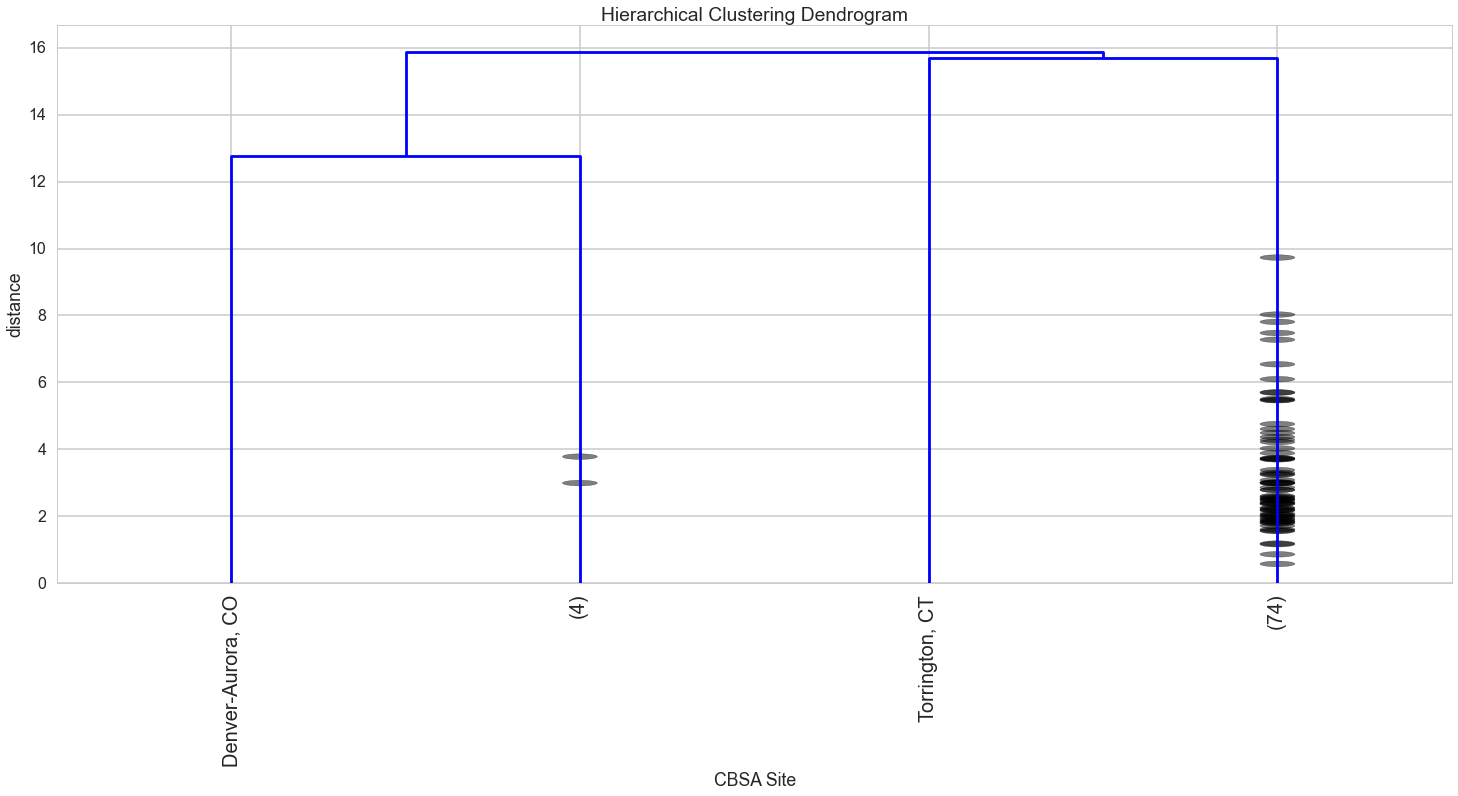

In [26]:
#Code from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
X1 = np.array(b)
Z1 = hac.linkage(X1, 'average')
#Here we do clustering with four groups
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('CBSA Site')
plt.ylabel('distance')
hac.dendrogram(
    Z1,
    truncate_mode='lastp',
    p=4,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    show_contracted=True,
    labels = np.array(a['CBSA Name'])
)
plt.show()

In [27]:
# More from 
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import fcluster
max_d = 11
clusters = fcluster(Z1, max_d, criterion='distance')
clusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [28]:
#Find the name of the CBSAs in each cluster
a['label']=clusters  #re-name the clusters

#print CBSA names by cluster
print 'CBSAs in Cluster 0'
print a[a['label']==1]['CBSA Name']
print
print 'CBSAs in Cluster 1'
print a[a['label']==2]['CBSA Name']
print
print 'CBSAs in Cluster 2'
print a[a['label']==3]['CBSA Name']
print
print 'CBSAs in Cluster 3'
print a[a['label']==4]['CBSA Name']
print

CBSAs in Cluster 0
90     Davenport-Moline-Rock Island, IA-IL
106    El Centro, CA                      
275    Phoenix-Mesa-Scottsdale, AZ        
314    Salt Lake City, UT                 
Name: CBSA Name, dtype: object

CBSAs in Cluster 1
95    Denver-Aurora, CO
Name: CBSA Name, dtype: object

CBSAs in Cluster 2
10     Allentown-Bethlehem-Easton, PA-NJ           
21     Atlanta-Sandy Springs-Marietta, GA          
27     Baltimore-Towson, MD                        
30     Baton Rouge, LA                             
42     Boise City-Nampa, ID                        
44     Boston-Cambridge-Quincy, MA-NH              
50     Bridgeport-Stamford-Norwalk, CT             
66     Charleston-North Charleston, SC             
67     Charlotte-Gastonia-Concord, NC-SC           
71     Chicago-Naperville-Joliet, IL-IN-WI         
73     Cincinnati-Middletown, OH-KY-IN             
79     Cleveland-Elyria-Mentor, OH                 
82     Columbia, SC                                
88     

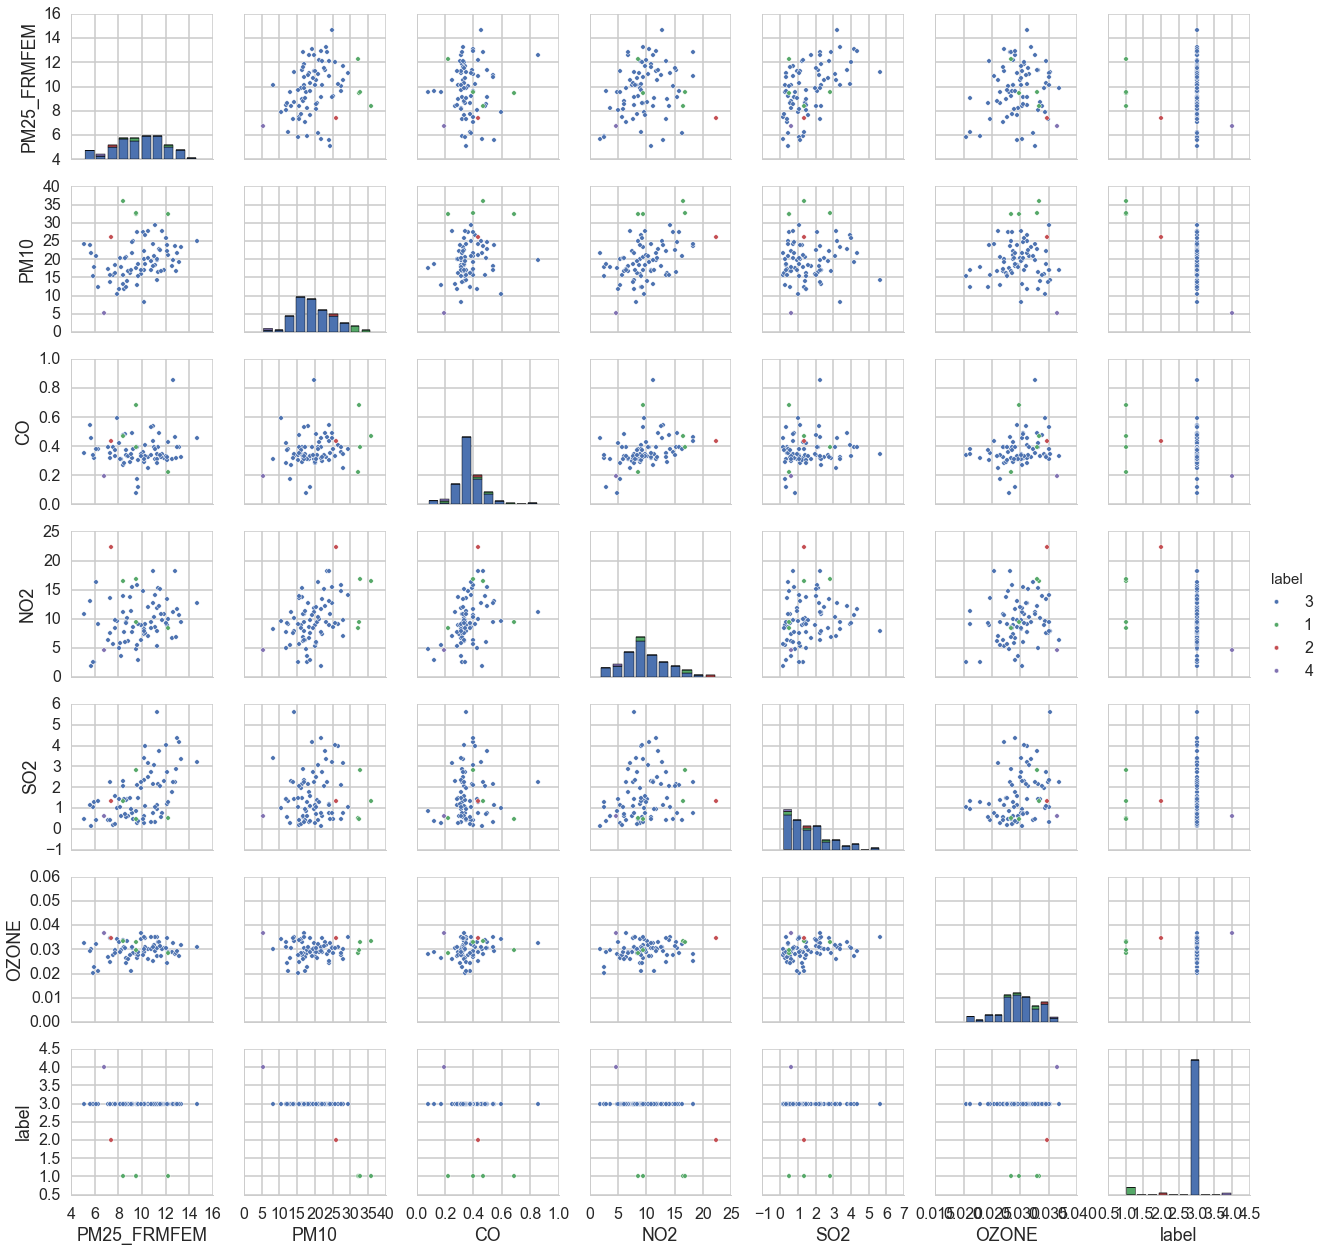

In [29]:
sns.pairplot(a, hue="label")

We see that Torrington, CT and Denver-Aurora, CO fall in their own clusters.  Using k-means we also found that they were in separate clusters (cluster 1 and cluster 3 respectively).  We also found with heirarchical clustering that Davenport-Moline-Rock Island, IA-IL; El Centro, CA; Phoenix-Mesa-Scottsdale, AZ; Salt Lake City, UT are all clustered together. In k-means they are all in the same cluster as well (cluster 3) though they are in the same cluster as Denver-Aurora, CO.  However heirarchical clustering clearly separated Denver-Aurora, CO from these four CBSAs.  

We decided to use k-means clusters as our overall clusters for applying labels to each of the CBSAs.


However we wondered what would happen if we re-ran heirarchical clustering without our two 'very different' CBSAs of Torrington, CT and Denver-Aurora, CO which are being clustered alone.  Would we see similar clustering to kmeans?  Are those two CBSAs throwing off heirarchical clustering?  Or do the two methods just produce different results?

In [30]:
#Remove Torrington, CT and Denver-Aurora, CO 
# that fell into in their own clusters
a_2 = a[a['label'] != 2]
a_2 = a_2[a_2['label'] != 4]
b_2 = a_2 [['PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE']]
X2 = np.array(b_2)
Z2 = hac.linkage(X2, 'average')

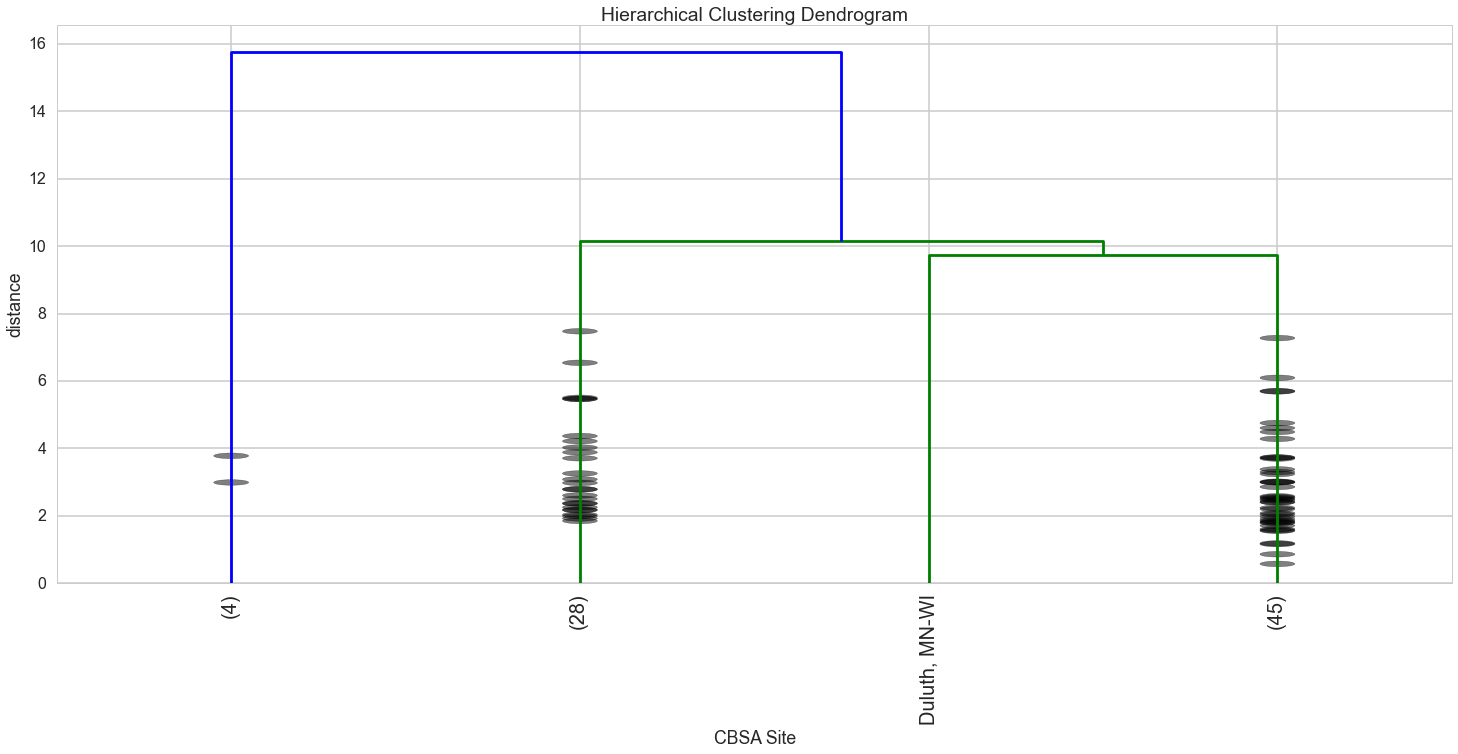

In [31]:
#Code from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
#Here we do clustering with four groups
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('CBSA Site')
plt.ylabel('distance')
hac.dendrogram(
    Z2,
    truncate_mode='lastp',
    p=4,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=20.,  # font size for the x axis labels
    show_contracted=True,
    labels = np.array(a_2['CBSA Name'])
)
plt.show()

In [32]:
# More from 
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import fcluster
max_d = 9
clusters = fcluster(Z2, max_d, criterion='distance')
clusters

array([3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 1, 3, 2, 4, 1, 2, 3, 3, 2,
       3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 2,
       1, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       2, 3, 3, 3, 2, 3, 3, 3, 2], dtype=int32)

In [33]:
#Find the name of the CBSAs in each cluster
a_2['label']=clusters  #re-name the clusters

#print CBSA names by cluster
print 'CBSAs in Cluster 0'
print a_2[a_2['label']==1]['CBSA Name']
print
print 'CBSAs in Cluster 1'
print a_2[a_2['label']==2]['CBSA Name']
print
print 'CBSAs in Cluster 2'
print a_2[a_2['label']==3]['CBSA Name']
print
print 'CBSAs in Cluster 3'
print a_2[a_2['label']==4]['CBSA Name']
print

CBSAs in Cluster 0
90     Davenport-Moline-Rock Island, IA-IL
106    El Centro, CA                      
275    Phoenix-Mesa-Scottsdale, AZ        
314    Salt Lake City, UT                 
Name: CBSA Name, dtype: object

CBSAs in Cluster 1
30     Baton Rouge, LA                                   
67     Charlotte-Gastonia-Concord, NC-SC                 
71     Chicago-Naperville-Joliet, IL-IN-WI               
73     Cincinnati-Middletown, OH-KY-IN                   
79     Cleveland-Elyria-Mentor, OH                       
97     Detroit-Warren-Livonia, MI                        
108    El Paso, TX                                       
115    Evansville, IN-KY                                 
133    Fresno, CA                                        
172    Houston-Sugar Land-Baytown, TX                    
176    Indianapolis-Carmel, IN                           
183    Johnstown, PA                                     
188    Kansas City, MO-KS                                
213 

Again we see a cluster with the four CBSAs: Davenport-Moline-Rock Island, IA-IL; El Centro, CA; Phoenix-Mesa-Scottsdale, AZ; Salt Lake City, UT.  We also have a cluster with Duluth, MN-WI by itself.  

In the Cluster 1 above from hierarchical clustering, we see that in both kmeans and in this clustering the following 13 CBSAs are clustered together: Baton Rouge, LA; Chicago-Naperville-Joliet, IL-IN-WI; El Paso, TX; Fresno, CA; Indianapolis-Carmel, IN; Kansas City, MO-KS; Los Angeles-Long Beach-Santa Ana, CA; Minneapolis-St. Paul-Bloomington, MN-WI; New York-Northern New Jersey-Long Island, NY-NJ-PA; Ogden-Clearfield, UT; San Diego-Carlsbad-San Marcos, CA; St. Louis, MO-IL; Tucson, AZ.

In Cluster 2 above from hierarchical clustering, we see that in both kmeans and in this clustering the following 13 CBSAs are clustered together: Allentown-Bethlehem-Easton, PA-NJ; Baltimore-Towson, MD; Boise City-Nampa, ID; Des Moines-West Des Moines, IA; Greenville-Mauldin-Easley, SC; Jacksonville, FL; New Haven-Milford, CT; Portland-South Portland-Biddeford, ME; San Francisco-Oakland-Fremont, CA; San Jose-Sunnyvale-Santa Clara, CA; Tulsa, OK; Winston-Salem, NC; Worcester, MA.

This clustering is definitely more similar to k means clustering and thus we move forward with the k means labeling of the clusters.  We also ran the k-means algorithm 1000 times and found our clustering to have the smallest withinness.  We did this four times and always found the same clustering scheme with the smallest withinness which increases our confidence in using the k means clustering labels.

### Are the distributions of other variables (population, weather, etc.) similar in a cluster?


In [37]:
cluster0_allVars=YearDat[YearDat['CBSA Name'].isin(dfClusters[dfClusters['Cluster']==0]['CBSA'])]
cluster0_allVars.head()

,CBSA Name,Latitude,Longitude,PM25_FRMFEM,AQI_PM25_FRMFEM,PM25_NOFRMFEM,AQI_PM25_NOFRMFEM,PM10,AQI_PM10,CO,AQI_CO,NO2,AQI_NO2,OZONE,AQI_OZONE,SO2,AQI_SO2,id,MetArea,pop2010,landarea,popdense2010,pop_weight2010,alone,alone_frac,carpool,carpool_frac,other,other_frac,pt,pt_frac,total_trans,Precip,Pressure,RH,Site,Temp,Wind
10,"Allentown-Bethlehem-Easton, PA-NJ",40.658948,-75.326473,11.894283,41.578465,8.875314,36.015504,17.064607,15.745787,0.320375,3.707865,10.760570,21.220670,0.030632,44.355039,2.286398,14.216630,10900,Metropolitan Statistical Area,821173,1453.2,565.1,3889.3,277398,0.821185,28982,0.085796,27152,0.080378,4270,0.012641,337802,1795.7,1014.146143,NaN,725170-14737-2010,53.019737,6.043802
27,"Baltimore-Towson, MD",39.297991,-76.583407,11.382332,42.351058,11.822581,44.451613,16.335294,15.070588,0.391457,5.723280,15.323582,28.185449,0.033142,46.124922,2.150568,7.210674,12580,Metropolitan Statistical Area,2710489,2601.5,1041.9,5435.7,1003492,0.773248,124112,0.095635,103125,0.079464,67034,0.051653,1297763,1509.2,1014.689296,NaN,745944-93784-2010,59.826297,NaN
42,"Boise City-Nampa, ID",43.593458,-116.424149,11.134189,40.212598,6.688430,27.231405,18.307471,16.844828,0.311235,4.959936,8.629604,21.984190,0.029370,37.437500,0.334688,0.692521,14260,Metropolitan Statistical Area,616561,11765.6,52.4,2310.2,215744,0.792047,23667,0.086887,31721,0.116455,1256,0.004611,272388,NaN,NaN,NaN,720734-99999-2010,56.726420,5.271260
67,"Charlotte-Gastonia-Concord, NC-SC",35.248844,-80.880219,11.270964,43.902538,11.447948,44.926396,19.712381,18.232381,0.314959,5.157534,11.787743,24.054795,0.030348,41.825132,0.933421,3.795518,16740,Metropolitan Statistical Area,1758038,3085.2,569.8,1881.3,838594,0.809502,103936,0.100330,75704,0.073078,17704,0.017090,1035938,1359.3,1016.142223,NaN,723140-13881-2010,60.587535,5.050659
73,"Cincinnati-Middletown, OH-KY-IN",39.191549,-84.432839,13.283674,49.550058,8.725983,36.941645,23.262295,21.547541,0.326002,4.130178,9.373849,18.895035,0.031885,45.105729,3.369288,17.938854,17140,Metropolitan Statistical Area,2130151,4391.9,485.0,2563.6,815330,0.828224,85256,0.086604,63783,0.064792,20063,0.020380,984432,1241.0,1016.754625,NaN,724297-93812-2010,53.301838,4.382788


CLUSTER 0
Out of 38 CBSAs in this cluster, 38 are metropolitan (100.00 percent)


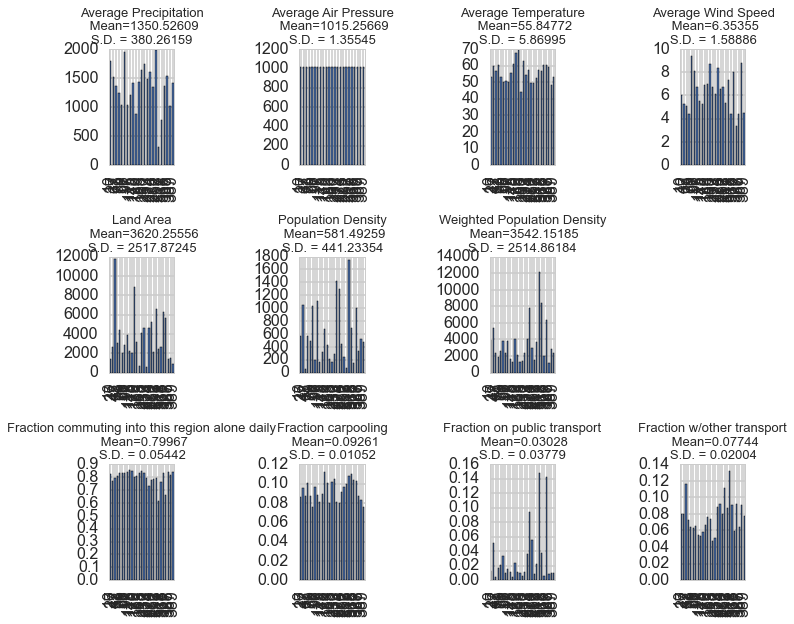

In [38]:
#Subset YearDat to CBSAs in Cluster 0
cluster0_allVars=YearDat[YearDat['CBSA Name'].isin(dfClusters[dfClusters['Cluster']==0]['CBSA'])]

#Subset YearDat to CBSAs in Cluster 1
cluster1_allVars=YearDat[YearDat['CBSA Name'].isin(dfClusters[dfClusters['Cluster']==1]['CBSA'])]

#Subset YearDat to CBSAs in Cluster 2
cluster2_allVars=YearDat[YearDat['CBSA Name'].isin(dfClusters[dfClusters['Cluster']==2]['CBSA'])]

#Subset YearDat to CBSAs in Cluster 3
cluster3_allVars=YearDat[YearDat['CBSA Name'].isin(dfClusters[dfClusters['Cluster']==3]['CBSA'])]


print 'CLUSTER 0'
clustertouse = cluster0_allVars
#Weather variables
plt.subplot(3, 5, 1)
vals = clustertouse[~np.isnan(clustertouse['Precip'])]['Precip']
vals.plot(kind='bar')
plt.title('Average Precipitation\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 2)
vals = clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure']
vals.plot(kind='bar')
plt.title('Average Air Pressure\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 3)
vals = clustertouse[~np.isnan(clustertouse['Temp'])]['Temp']
vals.plot(kind='bar')
plt.title('Average Temperature\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 4)
vals = clustertouse[~np.isnan(clustertouse['Wind'])]['Wind']
vals.plot(kind='bar')
plt.title('Average Wind Speed\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

#Population variables
metro = clustertouse[clustertouse['MetArea']=='Metropolitan Statistical Area']
print 'Out of %d CBSAs in this cluster, %d are metropolitan (%0.2f percent)'%(clustertouse.shape[1],metro.shape[1],(metro.shape[1]/float(clustertouse.shape[1])*100))

plt.subplot(3, 5, 6)
vals = clustertouse[~np.isnan(clustertouse['landarea'])]['landarea']
vals.plot(kind='bar')
plt.title('Land Area\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 7)
vals = clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010']
vals.plot(kind='bar')
plt.title('Population Density\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 8)
vals = clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010']
vals.plot(kind='bar')
plt.title('Weighted Population Density\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

#Transportation variables
plt.subplot(3, 5, 11)
vals = clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac']
vals.plot(kind='bar')
plt.title('Fraction commuting into this region alone daily\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 12)
vals = clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac']
vals.plot(kind='bar')
plt.title('Fraction carpooling\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 13)
vals = clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac']
vals.plot(kind='bar')
plt.title('Fraction on public transport\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 14)
vals = clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac']
vals.plot(kind='bar')
plt.title('Fraction w/other transport\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.tight_layout()

CLUSTER 1
Out of 38 CBSAs in this cluster, 38 are metropolitan (100.00 percent)


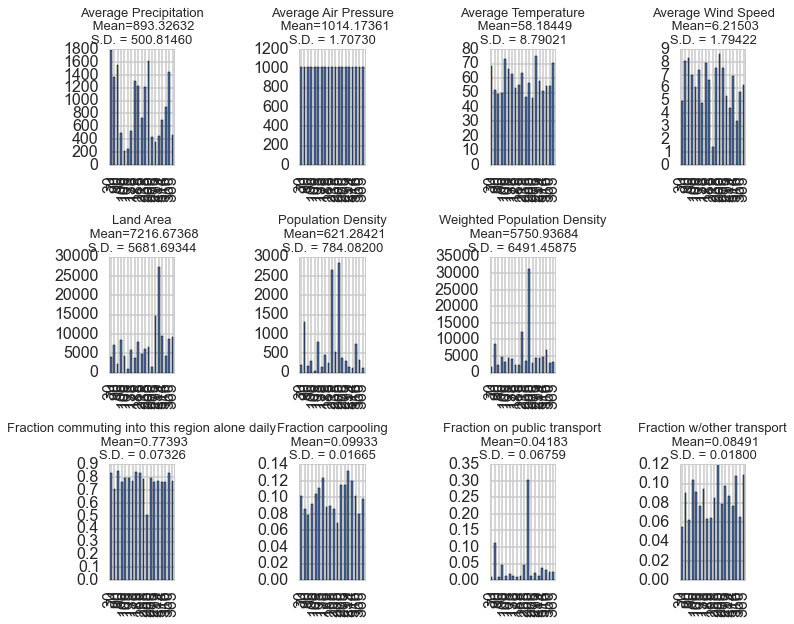

In [39]:
clustertouse = cluster1_allVars
print 'CLUSTER 1'
#Weather variables
plt.subplot(3, 5, 1)
vals = clustertouse[~np.isnan(clustertouse['Precip'])]['Precip']
vals.plot(kind='bar')
plt.title('Average Precipitation\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 2)
vals = clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure']
vals.plot(kind='bar')
plt.title('Average Air Pressure\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 3)
vals = clustertouse[~np.isnan(clustertouse['Temp'])]['Temp']
vals.plot(kind='bar')
plt.title('Average Temperature\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 4)
vals = clustertouse[~np.isnan(clustertouse['Wind'])]['Wind']
vals.plot(kind='bar')
plt.title('Average Wind Speed\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

#Population variables
metro = clustertouse[clustertouse['MetArea']=='Metropolitan Statistical Area']
print 'Out of %d CBSAs in this cluster, %d are metropolitan (%0.2f percent)'%(clustertouse.shape[1],metro.shape[1],(metro.shape[1]/float(clustertouse.shape[1])*100))

plt.subplot(3, 5, 6)
vals = clustertouse[~np.isnan(clustertouse['landarea'])]['landarea']
vals.plot(kind='bar')
plt.title('Land Area\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 7)
vals = clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010']
vals.plot(kind='bar')
plt.title('Population Density\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 8)
vals = clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010']
vals.plot(kind='bar')
plt.title('Weighted Population Density\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

#Transportation variables
plt.subplot(3, 5, 11)
vals = clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac']
vals.plot(kind='bar')
plt.title('Fraction commuting into this region alone daily\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 12)
vals = clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac']
vals.plot(kind='bar')
plt.title('Fraction carpooling\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 13)
vals = clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac']
vals.plot(kind='bar')
plt.title('Fraction on public transport\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 14)
vals = clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac']
vals.plot(kind='bar')
plt.title('Fraction w/other transport\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.tight_layout()

CLUSTER 2
Out of 37 CBSAs in this cluster, 37 are metropolitan (100.00 percent)


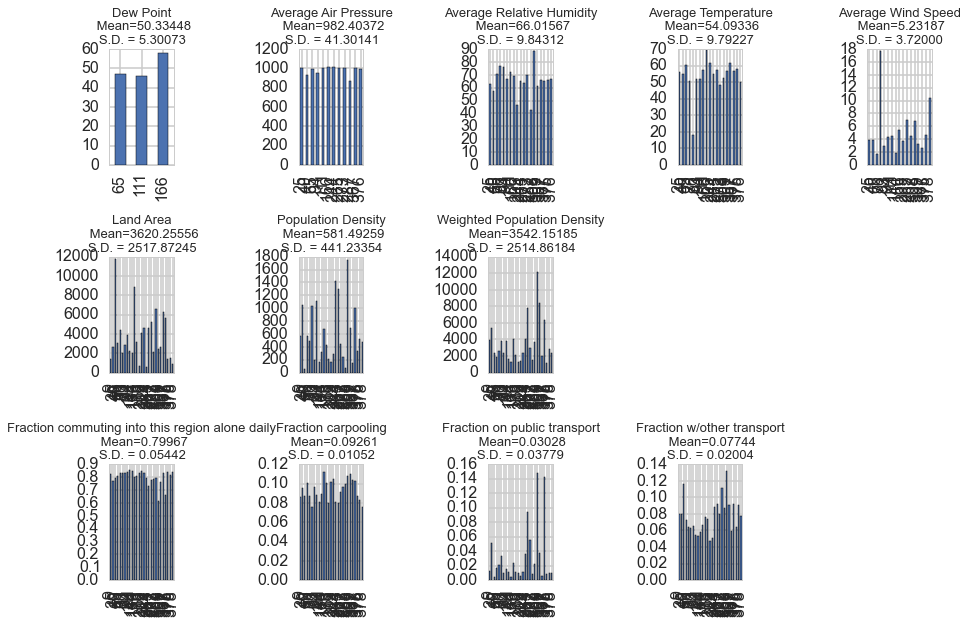

In [85]:
clustertouse = cluster2_allVars
print 'CLUSTER 2'
#Weather variables
plt.subplot(3, 5, 1)
vals = clustertouse[~np.isnan(clustertouse['DP'])]['DP']
vals.plot(kind='bar')
plt.title('Dew Point\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 2)
vals = clustertouse[~np.isnan(clustertouse['PRESS'])]['PRESS']
vals.plot(kind='bar')
plt.title('Average Air Pressure\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 3)
vals = clustertouse[~np.isnan(clustertouse['RH'])]['RH']
vals.plot(kind='bar')
plt.title('Average Relative Humidity\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 4)
vals = clustertouse[~np.isnan(clustertouse['TEMP'])]['TEMP']
vals.plot(kind='bar')
plt.title('Average Temperature\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 5)
vals = clustertouse[~np.isnan(clustertouse['WIND'])]['WIND']
vals.plot(kind='bar')
plt.title('Average Wind Speed\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

#Population variables
metro = clustertouse[clustertouse['MetArea']=='Metropolitan Statistical Area']
print 'Out of %d CBSAs in this cluster, %d are metropolitan (%0.2f percent)'%(clustertouse.shape[1],metro.shape[1],(metro.shape[1]/float(clustertouse.shape[1])*100))

plt.subplot(3, 5, 6)
vals = clustertouse[~np.isnan(clustertouse['landarea'])]['landarea']
vals.plot(kind='bar')
plt.title('Land Area\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 7)
vals = clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010']
vals.plot(kind='bar')
plt.title('Population Density\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 8)
vals = clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010']
vals.plot(kind='bar')
plt.title('Weighted Population Density\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

#Transportation variables
plt.subplot(3, 5, 11)
vals = clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac']
vals.plot(kind='bar')
plt.title('Fraction commuting into this region alone daily\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 12)
vals = clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac']
vals.plot(kind='bar')
plt.title('Fraction carpooling\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 13)
vals = clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac']
vals.plot(kind='bar')
plt.title('Fraction on public transport\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 14)
vals = clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac']
vals.plot(kind='bar')
plt.title('Fraction w/other transport\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.tight_layout()

CLUSTER 3
Out of 38 CBSAs in this cluster, 38 are metropolitan (100.00 percent)


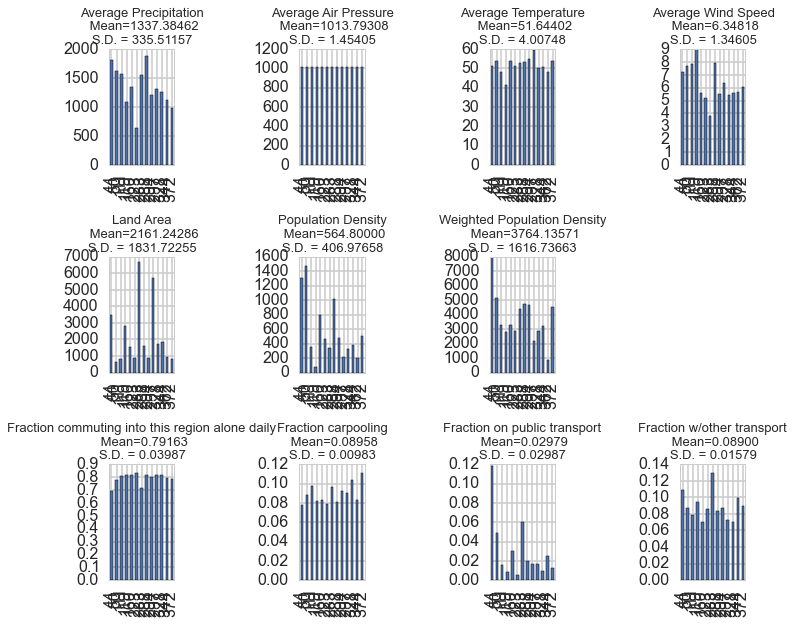

In [40]:
clustertouse = cluster3_allVars
print 'CLUSTER 3'
#Weather variables
plt.subplot(3, 5, 1)
vals = clustertouse[~np.isnan(clustertouse['Precip'])]['Precip']
vals.plot(kind='bar')
plt.title('Average Precipitation\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 2)
vals = clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure']
vals.plot(kind='bar')
plt.title('Average Air Pressure\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 3)
vals = clustertouse[~np.isnan(clustertouse['Temp'])]['Temp']
vals.plot(kind='bar')
plt.title('Average Temperature\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 4)
vals = clustertouse[~np.isnan(clustertouse['Wind'])]['Wind']
vals.plot(kind='bar')
plt.title('Average Wind Speed\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

#Population variables
metro = clustertouse[clustertouse['MetArea']=='Metropolitan Statistical Area']
print 'Out of %d CBSAs in this cluster, %d are metropolitan (%0.2f percent)'%(clustertouse.shape[1],metro.shape[1],(metro.shape[1]/float(clustertouse.shape[1])*100))

plt.subplot(3, 5, 6)
vals = clustertouse[~np.isnan(clustertouse['landarea'])]['landarea']
vals.plot(kind='bar')
plt.title('Land Area\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 7)
vals = clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010']
vals.plot(kind='bar')
plt.title('Population Density\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 8)
vals = clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010']
vals.plot(kind='bar')
plt.title('Weighted Population Density\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

#Transportation variables
plt.subplot(3, 5, 11)
vals = clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac']
vals.plot(kind='bar')
plt.title('Fraction commuting into this region alone daily\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 12)
vals = clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac']
vals.plot(kind='bar')
plt.title('Fraction carpooling\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 13)
vals = clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac']
vals.plot(kind='bar')
plt.title('Fraction on public transport\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.subplot(3, 5, 14)
vals = clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac']
vals.plot(kind='bar')
plt.title('Fraction w/other transport\n Mean=%0.5f\nS.D. = %0.5f'%(np.mean(vals),np.std(vals)),fontsize=13)

plt.tight_layout()

It was difficult to tell the differences by cluster across these graphs given how many there were.  So we looked at just the means to compare them, without the visual graphics, to try to see trends.

In [44]:
d=[]
clustertouse=cluster0_allVars #cluster 0
#Weather variables: 'Precip', 'Pressure', 'Temp', 'Wind'
d.append({'Cluster':0,'Variable':'Precip','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Precip'])]['Precip']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Precip'])]['Precip'])})
d.append({'Cluster':0,'Variable':'Pressure','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure'])})
d.append({'Cluster':0,'Variable':'Temp','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Temp'])]['Temp']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Temp'])]['Temp'])})
d.append({'Cluster':0,'Variable':'Wind','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Wind'])]['Wind']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Wind'])]['Wind'])})
#Population variables
d.append({'Cluster':0,'Variable':'landarea','Mean':np.mean(clustertouse[~np.isnan(clustertouse['landarea'])]['landarea']),'Std':np.std(clustertouse[~np.isnan(clustertouse['landarea'])]['landarea'])})
d.append({'Cluster':0,'Variable':'popdense2010','Mean':np.mean(clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010']),'Std':np.std(clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010'])})
d.append({'Cluster':0,'Variable':'pop_weight2010','Mean':np.mean(clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010']),'Std':np.std(clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010'])})
#Transportation variables
d.append({'Cluster':0,'Variable':'alone_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac'])})
d.append({'Cluster':0,'Variable':'carpool_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac'])})
d.append({'Cluster':0,'Variable':'pt_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac'])})
d.append({'Cluster':0,'Variable':'other_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac'])})

clustertouse=cluster1_allVars #cluster 1
#Weather variables
d.append({'Cluster':1,'Variable':'Precip','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Precip'])]['Precip']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Precip'])]['Precip'])})
d.append({'Cluster':1,'Variable':'Pressure','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure'])})
d.append({'Cluster':1,'Variable':'Temp','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Temp'])]['Temp']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Temp'])]['Temp'])})
d.append({'Cluster':1,'Variable':'Wind','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Wind'])]['Wind']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Wind'])]['Wind'])})
#Population variables
d.append({'Cluster':1,'Variable':'landarea','Mean':np.mean(clustertouse[~np.isnan(clustertouse['landarea'])]['landarea']),'Std':np.std(clustertouse[~np.isnan(clustertouse['landarea'])]['landarea'])})
d.append({'Cluster':1,'Variable':'popdense2010','Mean':np.mean(clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010']),'Std':np.std(clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010'])})
d.append({'Cluster':1,'Variable':'pop_weight2010','Mean':np.mean(clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010']),'Std':np.std(clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010'])})
#Transportation variables
d.append({'Cluster':1,'Variable':'alone_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac'])})
d.append({'Cluster':1,'Variable':'carpool_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac'])})
d.append({'Cluster':1,'Variable':'pt_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac'])})
d.append({'Cluster':1,'Variable':'other_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac'])})

clustertouse=cluster2_allVars #cluster 2
#Weather variables
d.append({'Cluster':2,'Variable':'Precip','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Precip'])]['Precip']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Precip'])]['Precip'])})
d.append({'Cluster':2,'Variable':'Pressure','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure'])})
d.append({'Cluster':2,'Variable':'Temp','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Temp'])]['Temp']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Temp'])]['Temp'])})
d.append({'Cluster':2,'Variable':'Wind','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Wind'])]['Wind']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Wind'])]['Wind'])})
#Population variables
d.append({'Cluster':2,'Variable':'landarea','Mean':np.mean(clustertouse[~np.isnan(clustertouse['landarea'])]['landarea']),'Std':np.std(clustertouse[~np.isnan(clustertouse['landarea'])]['landarea'])})
d.append({'Cluster':2,'Variable':'popdense2010','Mean':np.mean(clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010']),'Std':np.std(clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010'])})
d.append({'Cluster':2,'Variable':'pop_weight2010','Mean':np.mean(clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010']),'Std':np.std(clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010'])})
#Transportation variables
d.append({'Cluster':2,'Variable':'alone_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac'])})
d.append({'Cluster':2,'Variable':'carpool_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac'])})
d.append({'Cluster':2,'Variable':'pt_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac'])})
d.append({'Cluster':2,'Variable':'other_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac'])})
     
clustertouse=cluster3_allVars #cluster 3
#Weather variables
d.append({'Cluster':3,'Variable':'Precip','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Precip'])]['Precip']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Precip'])]['Precip'])})
d.append({'Cluster':3,'Variable':'Pressure','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Pressure'])]['Pressure'])})
d.append({'Cluster':3,'Variable':'Temp','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Temp'])]['Temp']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Temp'])]['Temp'])})
d.append({'Cluster':3,'Variable':'Wind','Mean':np.mean(clustertouse[~np.isnan(clustertouse['Wind'])]['Wind']),'Std':np.std(clustertouse[~np.isnan(clustertouse['Wind'])]['Wind'])})
#Population variables
d.append({'Cluster':3,'Variable':'landarea','Mean':np.mean(clustertouse[~np.isnan(clustertouse['landarea'])]['landarea']),'Std':np.std(clustertouse[~np.isnan(clustertouse['landarea'])]['landarea'])})
d.append({'Cluster':3,'Variable':'popdense2010','Mean':np.mean(clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010']),'Std':np.std(clustertouse[~np.isnan(clustertouse['popdense2010'])]['popdense2010'])})
d.append({'Cluster':3,'Variable':'pop_weight2010','Mean':np.mean(clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010']),'Std':np.std(clustertouse[~np.isnan(clustertouse['pop_weight2010'])]['pop_weight2010'])})
#Transportation variables
d.append({'Cluster':3,'Variable':'alone_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['alone_frac'])]['alone_frac'])})
d.append({'Cluster':3,'Variable':'carpool_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['carpool_frac'])]['carpool_frac'])})
d.append({'Cluster':3,'Variable':'pt_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['pt_frac'])]['pt_frac'])})
d.append({'Cluster':3,'Variable':'other_frac','Mean':np.mean(clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac']),'Std':np.std(clustertouse[~np.isnan(clustertouse['other_frac'])]['other_frac'])})

dfMeans_otherVars=pd.DataFrame(d)

WEATHER VARIABLES


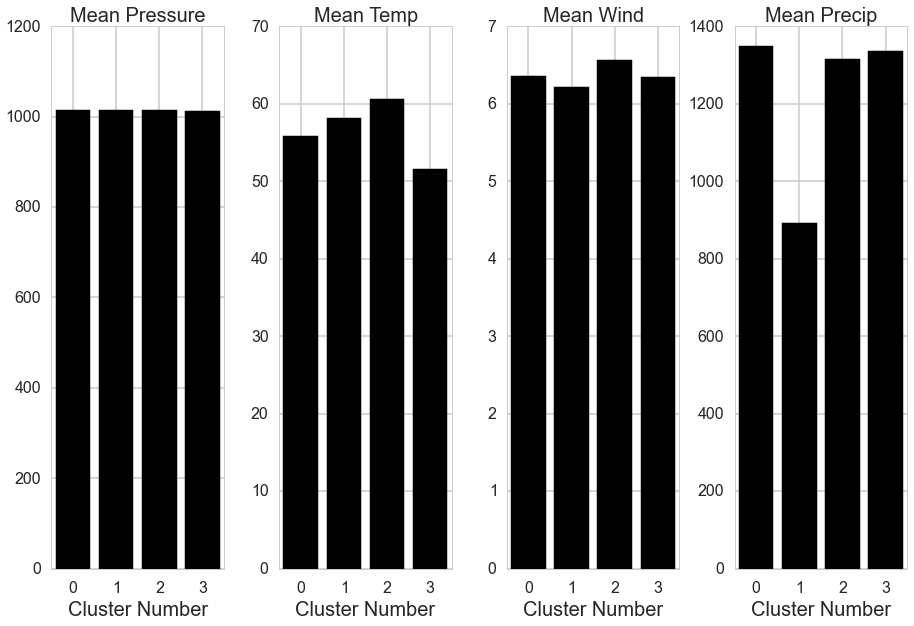

In [59]:
#Look at weather variables
#print dfMeans_otherVars[dfMeans_otherVars['Variable']=='Precip']
#print dfMeans_otherVars[dfMeans_otherVars['Variable']=='Pressure']
#print dfMeans_otherVars[dfMeans_otherVars['Variable']=='Temp']
#print dfMeans_otherVars[dfMeans_otherVars['Variable']=='Wind']


#Make a bar chart to visualize differences
names=['0','1','2','3']
variable_names=['Precip','Pressure','Temp','Wind']
print 'WEATHER VARIABLES'
for i in range(0,4):
    plt.subplot(1, 4, i)
    x=dfMeans_otherVars[dfMeans_otherVars['Variable']==variable_names[i]]['Cluster']
    y=dfMeans_otherVars[dfMeans_otherVars['Variable']==variable_names[i]]['Mean']
    plt.bar(x.values,y.values,color='black',align='center')
    plt.title('Mean ' + variable_names[i],fontsize=20)
    plt.xticks(x,names,horizontalalignment='center')
    plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=20)

plt.tight_layout()

It appears that all clusters have the same mean pressure.

We see that the clusters all differ in terms of mean temperature.  It appears as though cluster 3 might be most differentiated from the others by temperature.

We see that the clusters all differ in terms of mean wind speed but the differences are slight.  Both clusters 1 and 3 have lower mean wind speed on average than the other two clusters.

We see that the clusters all differ in terms of mean precipitation.  Cluster 1 is the most differentiated from the others by precipitation.

POPULATION VARIABLES


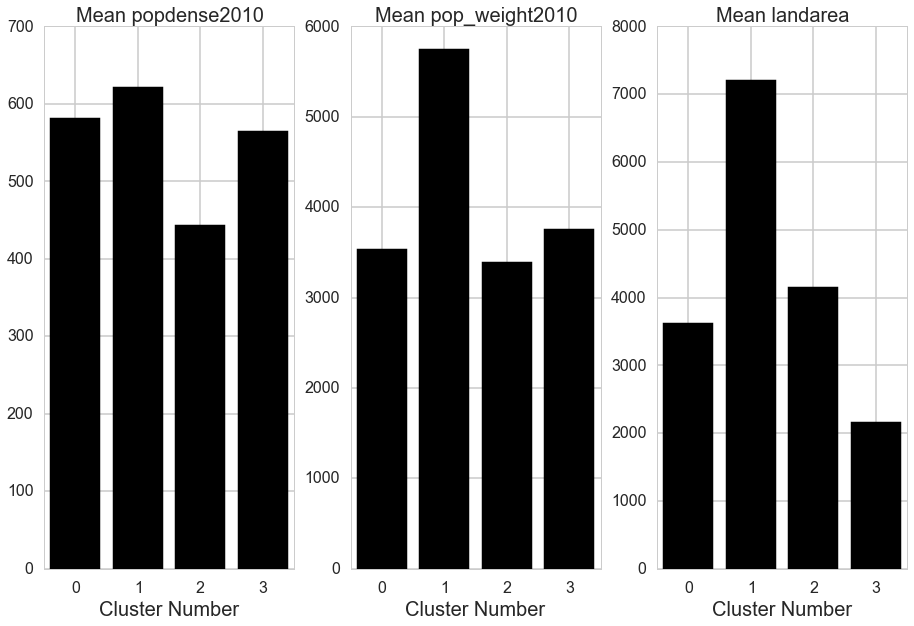

In [60]:
#Make a bar chart to visualize differences
names=['0','1','2','3']

#Population variables
variable_names=['landarea','popdense2010','pop_weight2010']
print 'POPULATION VARIABLES'
for i in range(0,3):
    plt.subplot(1, 3, i)
    x=dfMeans_otherVars[dfMeans_otherVars['Variable']==variable_names[i]]['Cluster']
    y=dfMeans_otherVars[dfMeans_otherVars['Variable']==variable_names[i]]['Mean']
    plt.bar(x.values,y.values,color='black',align='center')
    plt.title('Mean ' + variable_names[i],fontsize=20)
    plt.xticks(x,names,horizontalalignment='center')
    plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=20)
plt.tight_layout()

The clusters differ a lot by each of these variables based on population.

Cluster 1 is distinguished from the other three clusters as it has, by far, the greatest mean weighted population density for 2010 and the greatest mean land area.

Cluster 2 is differentiated the most from the others by having the lowest mean population density for 2010.  

Cluster 3 is differentiated the most from the others by having the smallest mean land area.  

TRANSPORTATION VARIABLES


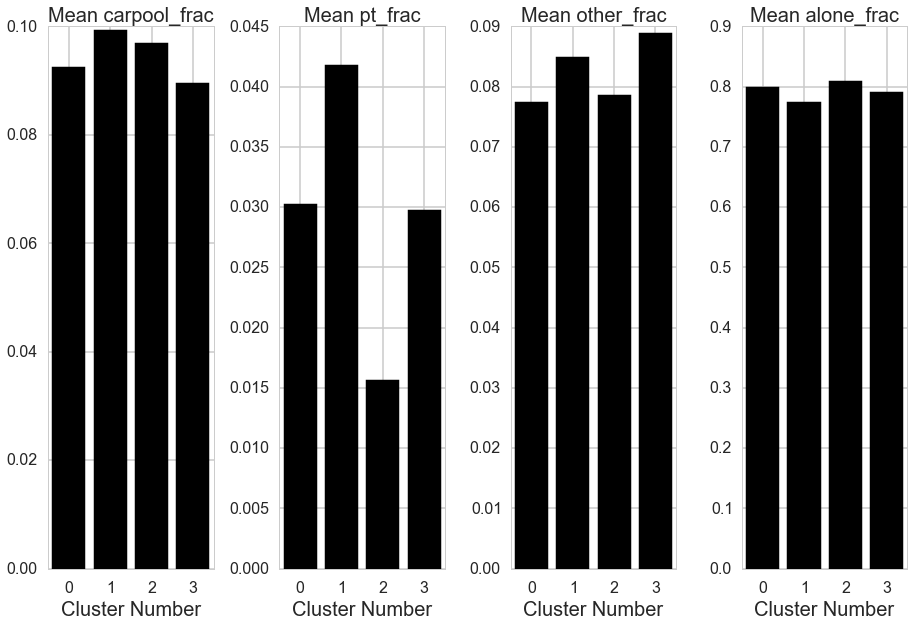

In [61]:

#Make a bar chart to visualize differences
names=['0','1','2','3']

#Transportation variables
variable_names=['alone_frac','carpool_frac','pt_frac','other_frac']
print 'TRANSPORTATION VARIABLES'
for i in range(0,4):
    plt.subplot(1, 4, i)
    x=dfMeans_otherVars[dfMeans_otherVars['Variable']==variable_names[i]]['Cluster']
    y=dfMeans_otherVars[dfMeans_otherVars['Variable']==variable_names[i]]['Mean']
    plt.bar(x.values,y.values,color='black',align='center')
    plt.title('Mean ' + variable_names[i],fontsize=20)
    plt.xticks(x,names,horizontalalignment='center')
    plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=20)
plt.tight_layout()

It appears that the mean percent of people commuting alone is about equal across all four clusters.

In terms of easily distinguishing clusters, the mean percent of people commuting by public transportation, is the variable that most easily separates cluster 1 and 2.  Cluster 2 has by far the lowest mean percent of people commuting by public transportation and Cluster 1 has by far the highest mean percent of people commuting by public transportation.

It appears that Cluster 3 is distinguished by highest mean percent of people commuting with other forms of transportation and lowest mean percent of people carpooling.

In all three sets of variables, we do not see any variables that clearly distinguish Cluster 0.

####Relationship of other predictors (weather, transportation, etc.) and cluster
We are interested in how other predictors and cluster are related.  A multinomial regression is therefore run.  The cluster number is the outcome and the predictors are variables such as TEMP, WIND, etc.  After the regression is run, we look at significance of Beta coefficients.

In [73]:
#Preform a multinomial regression
#Question?  Get weather data from Mark

#Subset yearDat to 80 CBSAs with no NANs for pollutants
YearDat_subset=YearDat[YearDat['CBSA Name'].isin(dfClusters['CBSA'])]  #shape is (80,38)
dfClusters_subset=dfClusters[['CBSA','Cluster']]
dfClusters_subset= dfClusters_subset.rename(columns={'CBSA': 'CBSA Name'})
#Add cluster number 
YearDat_subset=pd.merge(YearDat_subset,dfClusters_subset,on='CBSA Name',how='left')

#Preform a multinomial regression with all predictors

#Weather variables:'Precip''Pressure''Temp','Wind'
#Population variables:'landarea','popdense2010','pop_weight2010'
#Transportation variables:'alone_frac''carpool_frac''pt_frac','other_frac'

YearDat_subsetDropNA=YearDat_subset[['Cluster','Precip','Pressure','Temp','Wind','landarea','popdense2010','pop_weight2010','alone_frac','carpool_frac','pt_frac','other_frac']]
YearDat_subsetDropNA=YearDat_subsetDropNA.dropna()

import statsmodels.api as st
mdl = st.MNLogit(YearDat_subsetDropNA['Cluster'], YearDat_subsetDropNA[['Precip','Pressure','Temp','Wind','landarea','popdense2010','pop_weight2010','alone_frac','carpool_frac','pt_frac','other_frac']]) #multinomial regression
mdl_fit = mdl.fit()
print mdl_fit.summary()

Optimization terminated successfully.
         Current function value: 0.849765
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:                Cluster   No. Observations:                   69
Model:                        MNLogit   Df Residuals:                       36
Method:                           MLE   Df Model:                           30
Date:                Fri, 04 Dec 2015   Pseudo R-squ.:                  0.3790
Time:                        11:33:48   Log-Likelihood:                -58.634
converged:                       True   LL-Null:                       -94.418
                                        LLR p-value:                 2.984e-05
     Cluster=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Precip            -0.0005      0.001     -0.347      0.729        -0.003     0.002
Pressure        

When we run the full multi-nomial regression we see that the majority of predictor coefficients are not statistically significant.  The variable pop_weight2010 is the only one with a p-value below 0.05.

In [74]:
import statsmodels.api as st
#WEATHER
print 'WEATHER MODEL'
mdl = st.MNLogit(YearDat_subsetDropNA['Cluster'], YearDat_subsetDropNA[['Precip','Pressure','Temp','Wind']]) #multinomial regression
mdl_fit = mdl.fit()
print mdl_fit.summary()
#POPULATION
print 'POPULATION MODEL'
import statsmodels.api as st
mdl = st.MNLogit(YearDat_subsetDropNA['Cluster'], YearDat_subsetDropNA[['landarea','popdense2010','pop_weight2010']]) #multinomial regression
mdl_fit = mdl.fit()
print mdl_fit.summary()
#Transportation
print 'TRANSPORTATION MODEL'
import statsmodels.api as st
mdl = st.MNLogit(YearDat_subsetDropNA['Cluster'], YearDat_subsetDropNA[['alone_frac','carpool_frac','pt_frac','other_frac']]) #multinomial regression
mdl_fit = mdl.fit()
print mdl_fit.summary()

WEATHER MODEL
Optimization terminated successfully.
         Current function value: 1.180863
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                Cluster   No. Observations:                   69
Model:                        MNLogit   Df Residuals:                       57
Method:                           MLE   Df Model:                            9
Date:                Fri, 04 Dec 2015   Pseudo R-squ.:                  0.1370
Time:                        11:35:12   Log-Likelihood:                -81.480
converged:                       True   LL-Null:                       -94.418
                                        LLR p-value:                  0.002140
 Cluster=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Precip        -0.0022      0.001     -2.693      0.007        -0.004    -0.001
Pressure       

#QUESTION

### K Means Clustering With All Data (n=533)
We see if it is possible to do the K means with non-complete data. 
Turns out this algorithm cannot run with missing data. :(

In [112]:
#First convert our data set into a tuple
dataset_nonComplete = []
non_complete = YearDat[['CBSA Name','PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE']]

for index, row in non_complete.iterrows():
    rowTuple = tuple(row.tolist())
    dataset_nonComplete.append(rowTuple) 
    
#Do the kmeans clustering
clustering =kmeans(dataset_nonComplete,4)

#Do the kmeans clustering over and over
#clustering = repeatedKMeans(dataset,4, 1000)

#Print the centroid data ('PM25_FRMFEM','PM10','CO','NO2','SO2','OZONE')
printTable(clustering["centroids"])
print

#Print out each of the clusters
for i in xrange(0,len(clustering["clusters"])): #for each cluster list
    cbsa_names = []
    for tup in clustering["clusters"][i]:    #go through the tuples
        cbsa_names.append(tup[0])   #pull out the CBSA name and append to list
    #print the clusters
    print 'Cluster %d'% i
    print '%d CBSAs in this cluster' % len(cbsa_names)
    print cbsa_names
    print
    

KeyboardInterrupt: 

In [42]:
import random
lad = []
for i in range(80):
    q = random.random()
    if q <= 0.2:
        lad.append(1)
    elif (q > 0.2) and (q<=0.5):
        lad.append(2)
    elif (q > 0.5) and (q<=1):
        lad.append(3)

In [48]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

n_samples, n_features = b.shape
n_digits = 3
labels = lad

sample_size = 60

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 3, 	 n_samples 80, 	 n_features 6


In [49]:
n_digits

3

In [50]:
print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')

_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette


In [51]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=b)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=b)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(b)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=b)
print(79 * '_')

IndexError: indices are out-of-bounds

n_digits: 10, 	 n_samples 1797, 	 n_features 64
_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.20s    69432   0.602   0.650   0.625   0.465   0.598    0.146
   random   0.18s    69694   0.669   0.710   0.689   0.553   0.666    0.147
PCA-based   0.02s    71820   0.673   0.715   0.693   0.567   0.670    0.150
_______________________________________________________________________________


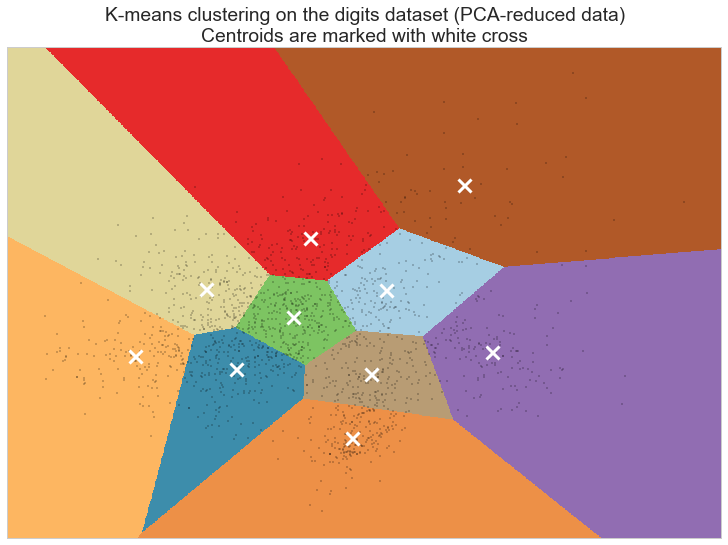

In [46]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


In [47]:
labels

array([0, 1, 2, ..., 8, 9, 8])